# 1. 전국 아파트 매매 데이터 1999 ~ 2024 합치기 glob
# 2. database에서 1999 ~ 2024 USD 환율정보 가져와 합치기
* 날짜와 USD 살 때 데이터만 사용
# 3. 전국 학원 정보 가져와서 합치기(시군구 단위)
# 4. 금리 정보 합치기
# 5. 회귀분석으로 집값 예측하기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pymysql
import time
import requests
from bs4 import BeautifulSoup as bs

In [2]:
file_path = "./data/apart1999_202408/"

all_files = glob.glob(os.path.join(file_path, "*.csv"))

In [3]:
# 데이터를 담을 리스트 초기화
data_list = []

# 각 파일을 반복문으로 처리
for file in all_files:
    try:
        # 파일을 읽을 때 low_memory=False 설정으로 DtypeWarning 방지
        df = pd.read_csv(file, encoding='cp949', skiprows=15, on_bad_lines='skip', low_memory=False)

        # 데이터가 비어 있지 않으면 리스트에 추가
        if not df.empty:
            data_list.append(df)
        else:
            print(f"파일에 데이터가 없습니다: {file}")
    except pd.errors.EmptyDataError:
        print(f"빈 데이터 파일 건너뛰기: {file}")
    except UnicodeDecodeError:
        print(f"인코딩 오류로 euc-kr 인코딩을 사용합니다: {file}")
        try:
            df = pd.read_csv(file, encoding='euc-kr', skiprows=15, on_bad_lines='skip', low_memory=False)
            if not df.empty:
                data_list.append(df)
            else:
                print(f"파일에 데이터가 없습니다: {file}")
        except pd.errors.EmptyDataError:
            print(f"빈 데이터 파일 건너뛰기: {file}")

# 모든 데이터프레임을 하나로 합치기
if data_list:
    combined_data = pd.concat(data_list, ignore_index=True)
    print(combined_data)
else:
    print("데이터가 포함된 파일이 없습니다.")

파일에 데이터가 없습니다: ./data/apart1999_202408\1999_01.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_02.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_03.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_04.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_05.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_06.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_07.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_08.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_09.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_10.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_11.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\1999_12.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_01.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_02.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_03.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_04.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_05.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_06.csv
파일에 데이터가 없습니다: ./data/apart1999_202408\2000_07.csv
파일에 데이터가 없습니다: ./data/apart1999

In [4]:
combined_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,NO,동,매수자,매도자,등기일자
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,양록길23번길 11,NaN,,-,-,NaN,NaN,NaN,NaN,NaN
1,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,오목로 73,NaN,,-,-,NaN,NaN,NaN,NaN,NaN
2,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,시민로245번길 10,NaN,,-,-,NaN,NaN,NaN,NaN,NaN
3,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,회룡로 245,NaN,,-,-,NaN,NaN,NaN,NaN,NaN
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,오목로 36,NaN,,-,-,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,인천광역시 서구 당하동,1090-1,1090,1.0,검단힐스테이트4차,107.4423,202408,1,"52,000",8,...,청마로 92,-,NaN,중개거래,인천 서구,41073.0,-,개인,개인,-
10041447,경기도 수원시 권선구 세류동,1255,1255,0.0,권선어울림,120.4100,202408,1,"58,800",9,...,세권로43번길 26-6,-,NaN,중개거래,경기 수원시 권선구,41074.0,-,개인,개인,-
10041448,울산광역시 울주군 온양읍 망양리,가-5-1,5,1.0,회야리버,39.7150,202408,1,"7,000",4,...,원동2길 19-2,-,NaN,직거래,-,41075.0,101,개인,개인,24.08.02
10041449,대전광역시 서구 둔산동,1510,1510,0.0,목련,101.8300,202408,1,"98,500",1,...,둔산남로 127,-,NaN,중개거래,대전 서구,41076.0,-,개인,개인,-


## Database에서 1999 ~ 2024 USD 환율정보 가져와 합치기

In [5]:
pymysql.install_as_MySQLdb()
load_dotenv(dotenv_path = '../../05_data_scraping/.env_db2')

True

In [6]:
print(f"Connected to database: {os.getenv('database')}")

Connected to database: korea_exchange_rate


In [7]:
# mysql에서 테이블 불러오기
engine = create_engine(f"{os.getenv('db')}+{os.getenv('dbtype')}://{os.getenv('id')}:{os.getenv('pw')}@{os.getenv('host')}/{os.getenv('database')}")
conn = engine.connect()
ex_data = pd.read_sql('SELECT * FROM exchange_rate', con=conn)
conn.close()

In [8]:
ex_data

,date,통화,현찰_살때_환율,현찰_살때_Spread,현찰_팔때_환율,현찰_팔때_Spread,송금_보낼때,송금_받을때,T/C_살때,외화_수표_팔때,매매기준율,환가_료율,미화 환산율
0,1995-01-03,미국 USD,800.53,1.5,776.87,1.5,791.80,785.60,792.64,0.00,788.70,0.00,1.0000
1,1995-01-03,일본 JPY (100),798.89,1.5,775.29,1.5,791.81,782.37,792.59,0.00,787.09,0.00,0.9980
2,1995-01-03,유로 EUR,0.00,0.0,0.00,0.0,975.40,959.92,0.00,957.94,967.66,7.37,1.2269
3,1995-01-03,중국 CNY,0.00,0.0,0.00,0.0,94.12,0.00,0.00,0.00,93.38,1.00,0.1184
4,1995-01-03,홍콩 HKD,103.45,3.0,100.41,3.0,102.74,101.12,0.00,0.00,101.93,0.00,0.1292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383631,2024-09-25,리비아 LYD,0.00,0.0,0.00,0.0,282.97,277.37,NaN,0.00,280.17,0.00,0.2105
383632,2024-09-25,루마니아 RON,0.00,0.0,0.00,0.0,0.00,0.00,NaN,0.00,299.10,0.00,0.2248
383633,2024-09-25,미얀마 MMK,0.00,0.0,0.00,0.0,0.00,0.00,NaN,0.00,0.63,0.00,0.0005
383634,2024-09-25,에티오피아 ETB,0.00,0.0,0.00,0.0,0.00,0.00,NaN,0.00,11.16,0.00,0.0084


In [9]:
us_data = ex_data[ex_data['통화'] == '미국 USD']

In [10]:
us_data

,date,통화,현찰_살때_환율,현찰_살때_Spread,현찰_팔때_환율,현찰_팔때_Spread,송금_보낼때,송금_받을때,T/C_살때,외화_수표_팔때,매매기준율,환가_료율,미화 환산율
0,1995-01-03,미국 USD,800.53,1.50,776.87,1.50,791.8,785.6,792.64,0.00,788.7,0.00000,1.0
22,1995-01-04,미국 USD,800.33,1.50,776.67,1.50,791.6,785.4,792.44,0.00,788.5,0.00000,1.0
44,1995-01-05,미국 USD,801.14,1.50,777.46,1.50,792.4,786.2,793.24,0.00,789.3,0.00000,1.0
66,1995-01-06,미국 USD,801.44,1.50,777.76,1.50,792.7,786.5,793.54,0.00,789.6,0.00000,1.0
88,1995-01-09,미국 USD,802.15,1.50,778.45,1.50,793.4,787.2,794.25,0.00,790.3,0.00000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383346,2024-09-19,미국 USD,1351.74,1.75,1305.26,1.75,1341.5,1315.5,NaN,1312.99,1328.5,6.81086,1.0
383404,2024-09-20,미국 USD,1357.34,1.75,1310.66,1.75,1347.0,1321.0,NaN,1318.50,1334.0,6.76991,1.0
383462,2024-09-23,미국 USD,1362.53,1.75,1315.67,1.75,1352.2,1326.0,NaN,1323.51,1339.1,6.70722,1.0
383520,2024-09-24,미국 USD,1359.38,1.75,1312.62,1.75,1349.0,1323.0,NaN,1320.52,1336.0,6.70478,1.0


In [11]:
us_data = us_data[['date','현찰_살때_환율']]

In [12]:
us_data

,date,현찰_살때_환율
0,1995-01-03,800.53
22,1995-01-04,800.33
44,1995-01-05,801.14
66,1995-01-06,801.44
88,1995-01-09,802.15
...,...,...
383346,2024-09-19,1351.74
383404,2024-09-20,1357.34
383462,2024-09-23,1362.53
383520,2024-09-24,1359.38


In [13]:
combined_data['계약년월'].astype(str)

0           200509
1           200510
2           200510
3           200510
4           200511
             ...  
10041446    202408
10041447    202408
10041448    202408
10041449    202408
10041450    202408
Name: 계약년월, Length: 10041451, dtype: object

In [14]:
combined_data['계약일'].astype(str)

0           23
1           30
2           20
3           20
4           21
            ..
10041446     1
10041447     1
10041448     1
10041449     1
10041450     1
Name: 계약일, Length: 10041451, dtype: object

In [15]:
combined_data['계약년월'].astype(str) + combined_data['계약일'].astype(str)

0           20050923
1           20051030
2           20051020
3           20051020
4           20051121
              ...   
10041446     2024081
10041447     2024081
10041448     2024081
10041449     2024081
10041450     2024081
Length: 10041451, dtype: object

In [16]:
combined_data['계약날짜'] = combined_data['계약년월'].astype(str) + combined_data['계약일'].astype(str)

In [17]:
# 혹시 몰라서 데이터 복사 해놓기
copy1 = combined_data.copy()

In [18]:
combined_data.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,해제사유발생일,등기신청일자,거래유형,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.400,200509,23,"5,000",11,...,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20050923
1,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.990,200510,30,"12,750",19,...,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051030
2,경기도 의정부시 신곡동,456,456,0.0,신일1,59.878,200510,20,"5,750",3,...,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051020
3,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.830,200510,20,"5,500",8,...,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051020
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.730,200511,21,"12,200",11,...,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051121


In [19]:
combined_data.drop(['계약년월', '계약일'], axis=1)

,시군구,번지,본번,부번,단지명,전용면적(㎡),거래금액(만원),층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,"5,000",11,1998.0,양록길23번길 11,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20050923
1,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,"12,750",19,2003.0,오목로 73,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051030
2,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,"5,750",3,1997.0,시민로245번길 10,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051020
3,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,"5,500",8,1998.0,회룡로 245,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051020
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,"12,200",11,1992.0,오목로 36,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,20051121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,인천광역시 서구 당하동,1090-1,1090,1.0,검단힐스테이트4차,107.4423,"52,000",8,2012.0,청마로 92,-,NaN,중개거래,인천 서구,41073.0,-,개인,개인,-,2024081
10041447,경기도 수원시 권선구 세류동,1255,1255,0.0,권선어울림,120.4100,"58,800",9,2010.0,세권로43번길 26-6,-,NaN,중개거래,경기 수원시 권선구,41074.0,-,개인,개인,-,2024081
10041448,울산광역시 울주군 온양읍 망양리,가-5-1,5,1.0,회야리버,39.7150,"7,000",4,2000.0,원동2길 19-2,-,NaN,직거래,-,41075.0,101,개인,개인,24.08.02,2024081
10041449,대전광역시 서구 둔산동,1510,1510,0.0,목련,101.8300,"98,500",1,1993.0,둔산남로 127,-,NaN,중개거래,대전 서구,41076.0,-,개인,개인,-,2024081


### 둘이 날짜를 비교해서 맞춰서 넣어야 되는데 날짜 형식이 맞지 않아서 동일하게 맞추기

In [20]:
us_data['date'] = pd.to_datetime(us_data['date'])
us_data

C:\Users\5-04\AppData\Local\Temp\ipykernel_12844\3744426289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_data['date'] = pd.to_datetime(us_data['date'])


,date,현찰_살때_환율
0,1995-01-03,800.53
22,1995-01-04,800.33
44,1995-01-05,801.14
66,1995-01-06,801.44
88,1995-01-09,802.15
...,...,...
383346,2024-09-19,1351.74
383404,2024-09-20,1357.34
383462,2024-09-23,1362.53
383520,2024-09-24,1359.38


In [21]:
us_data[us_data['date'] == '2005-10-28']

,date,현찰_살때_환율
97113,2005-10-28,1073.67


In [22]:
combined_data['계약날짜'] = pd.to_datetime(combined_data['계약날짜'], format='%Y%m%d', errors='coerce')

In [23]:
combined_data['계약날짜']

0          2005-09-23
1          2005-10-30
2          2005-10-20
3          2005-10-20
4          2005-11-21
              ...    
10041446   2024-08-01
10041447   2024-08-01
10041448   2024-08-01
10041449   2024-08-01
10041450   2024-08-01
Name: 계약날짜, Length: 10041451, dtype: datetime64[ns]

* 이렇게 진행하면 날짜가 안맞는것들이 생김
* 공휴일, 토, 일은 그 전날 데이터로 맵핑 해야됨

In [24]:
## 잘못!!!!!!!!!!!!!!!!!


# 병합 (계약날짜와 us_data의 date를 기준으로 병합)
merged_data = pd.merge(combined_data, us_data[['date', '현찰_살때_환율']], 
                       left_on='계약날짜', right_on='date', how='left')

# NaN 값이 있는 '현찰_살때_환율' 열에 대해 직전 영업일의 데이터로 채우기 (앞쪽으로 채움)
merged_data['현찰_살때_환율'] = merged_data['현찰_살때_환율'].ffill()

# 병합된 결과 확인
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,거래유형,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜,date,현찰_살때_환율
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83
1,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-30,NaT,1061.83
2,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02
3,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364499,인천광역시 서구 당하동,1090-1,1090,1.0,검단힐스테이트4차,107.4423,202408,1,"52,000",8,...,중개거래,인천 서구,41073.0,-,개인,개인,-,2024-08-01,2024-08-01,1394.99
12364500,경기도 수원시 권선구 세류동,1255,1255,0.0,권선어울림,120.4100,202408,1,"58,800",9,...,중개거래,경기 수원시 권선구,41074.0,-,개인,개인,-,2024-08-01,2024-08-01,1394.99
12364501,울산광역시 울주군 온양읍 망양리,가-5-1,5,1.0,회야리버,39.7150,202408,1,"7,000",4,...,직거래,-,41075.0,101,개인,개인,24.08.02,2024-08-01,2024-08-01,1394.99
12364502,대전광역시 서구 둔산동,1510,1510,0.0,목련,101.8300,202408,1,"98,500",1,...,중개거래,대전 서구,41076.0,-,개인,개인,-,2024-08-01,2024-08-01,1394.99


* pd.merge_asof() 사용하여 "날짜보다 작거나 같은 가장 가까운 날짜"의 데이터를 가져오는 방법

In [24]:
# 날짜를 기준으로 가장 가까운 과거 날짜를 찾아 병합 (계약날짜 기준으로 date의 가장 가까운 과거 환율 데이터를 찾아 병합)
merged_data = pd.merge_asof(combined_data.sort_values('계약날짜'), 
                            us_data[['date', '현찰_살때_환율']].sort_values('date'), 
                            left_on='계약날짜', 
                            right_on='date', 
                            direction='backward')

# 결과 확인
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,거래유형,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜,date,현찰_살때_환율
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,직거래,-,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,중개거래,경북 안동시,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,중개거래,"경북 구미시, 경북 칠곡군",1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,중개거래,"경남 양산시, 부산 부산진구",1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43


In [25]:
# 값이 빠진게 있는지 확인하기
merged_data['date'].isna().sum()

0

In [26]:
merged_data.rename(columns={'date': '환율날짜'}, inplace=True)

# 변경된 결과 확인
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,거래유형,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,-,-,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,직거래,-,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,중개거래,경북 안동시,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,중개거래,"경북 구미시, 경북 칠곡군",1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,중개거래,"경남 양산시, 부산 부산진구",1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43


In [27]:
merged_data['시군구'].unique()

array(['강원특별자치도 양구군 양구읍 상리', '경기도 의정부시 신곡동', '경기도 의정부시 민락동', ...,
       '부산광역시 강서구 강동동', '경상남도 창원시 마산합포구 구산면 수정리', '경상북도 경주시 건천읍 화천리'],
      dtype=object)

In [28]:
merged_data['시군구'].nunique()

4393

In [29]:
unique_sigungus = merged_data['시군구'].unique()
for sigungu in unique_sigungus:
    print(sigungu)

강원특별자치도 양구군 양구읍 상리
경기도 의정부시 신곡동
경기도 의정부시 민락동
경기도 의정부시 용현동
경상남도 창원성산구 남양동
경상남도 창원성산구 대방동
경상남도 창원성산구 반림동
경상남도 창원성산구 상남동
경상남도 창원성산구 안민동
경상남도 창원의창구 도계동
경상남도 창원진해구 경화동
경상남도 창원의창구 팔용동
경상남도 창원진해구 용원동
경상남도 창원진해구 풍호동
경상남도 통영시 무전동
경상남도 통영시 북신동
경상남도 함양군 함양읍 교산리
경상북도 경산시 사동
경상북도 경산시 삼북동
전라북도 전주덕진구 송천동1가
경상남도 창원성산구 가음동
경상남도 진주시 집현면 봉강리
경상남도 진주시 평거동
전라북도 전주덕진구 송천동2가
경상남도 진주시 호탄동
경상남도 창녕군 창녕읍 교리
경상남도 창원마산합포구 진동면 요장리
경상남도 창원마산회원구 구암동
경상남도 창원마산회원구 내서읍 삼계리
경상남도 창원마산회원구 내서읍 중리
경상남도 창원마산회원구 내서읍 호계리
경상남도 창원마산회원구 석전동
경상북도 경산시 압량읍 부적리
경상북도 경산시 옥곡동
경상북도 경산시 진량읍 부기리
경상북도 경산시 정평동
전라북도 완주군 삼례읍 삼례리
경상북도 포항남구 대잠동
경상북도 포항남구 연일읍 생지리
경상북도 포항북구 득량동
경상북도 포항북구 용흥동
경상북도 포항북구 창포동
광주광역시 광산구 도산동
광주광역시 광산구 소촌동
전라북도 군산시 지곡동
광주광역시 광산구 송정동
전라북도 군산시 조촌동
광주광역시 광산구 우산동
광주광역시 광산구 운남동
경상북도 청도군 청도읍 고수리
경상북도 울진군 후포면 삼율리
경상북도 영주시 가흥동
경상북도 상주시 복룡동
경상남도 진주시 신안동
전라북도 익산시 어양동
경상북도 경산시 진량읍 양기리
경상북도 경산시 진량읍 황제리
경상북도 경산시 하양읍 금락리
경상북도 경주시 충효동
경상북도 경주시 현곡면 금장리
경상북도 구미시 고아읍 원호리
전라북도 익산시 부송동
경상북도 경산시 옥산동
경상북도 구미시 비산동
경상북도 구미시 상모동
경상북도 구미시 옥계동
경상북

In [29]:
# '시군구' 컬럼을 공백으로 나누기
split_columns = merged_data['시군구'].str.split(' ', expand=True)

# '도'와 '시군'을 합친 새로운 열 생성 (예: '강원특별자치도 양구군')
merged_data['도_시군'] = split_columns[0] + ' ' + split_columns[1]

# 결과 확인
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,-,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,-,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,-,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,-,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,경북 안동시,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,"경북 구미시, 경북 칠곡군",1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,"경남 양산시, 부산 부산진구",1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시


In [30]:
merged_data['도_시군'].isna().sum()

0

In [32]:
unique_sigungus2 = merged_data['도_시군'].unique()
for sigungu in unique_sigungus2:
    print(sigungu)

강원특별자치도 양구군
경기도 의정부시
경상남도 창원성산구
경상남도 창원의창구
경상남도 창원진해구
경상남도 통영시
경상남도 함양군
경상북도 경산시
전라북도 전주덕진구
경상남도 진주시
경상남도 창녕군
경상남도 창원마산합포구
경상남도 창원마산회원구
전라북도 완주군
경상북도 포항남구
경상북도 포항북구
광주광역시 광산구
전라북도 군산시
경상북도 청도군
경상북도 울진군
경상북도 영주시
경상북도 상주시
전라북도 익산시
경상북도 경주시
경상북도 구미시
경상북도 김천시
경상남도 양산시
경기도 파주시
전라북도 전주완산구
경기도 평택시
경기도 이천시
경기도 의왕시
경기도 화성시
경상남도 거제시
경상남도 고성군
경상남도 김해시
경상남도 사천시
경기도 포천시
경기도 하남시
대구광역시 서구
대구광역시 수성구
전라남도 순천시
대구광역시 북구
대구광역시 동구
전라남도 여수시
대구광역시 중구
대전광역시 서구
전라남도 목포시
대전광역시 유성구
대전광역시 대덕구
대전광역시 동구
광주광역시 북구
광주광역시 서구
전라남도 해남군
광주광역시 남구
대구광역시 남구
대구광역시 달서구
대구광역시 달성군
경기도 시흥시
충청남도 천안동남구
경기도 수원팔달구
경기도 안산단원구
경기도 안산상록구
충청남도 아산시
경기도 수원장안구
경기도 수원권선구
충청남도 천안서북구
경기도 수원영통구
경기도 성남중원구
경기도 용인기흥구
경기도 용인수지구
충청남도 당진시
충청남도 서산시
충청남도 부여군
충청남도 보령시
경기도 용인처인구
충청남도 계룡시
경기도 안양동안구
경기도 안양만안구
경기도 양주시
경기도 오산시
대전광역시 중구
서울특별시 서초구
인천광역시 부평구
인천광역시 미추홀구
서울특별시 마포구
서울특별시 서대문구
서울특별시 성동구
서울특별시 성북구
서울특별시 도봉구
서울특별시 동대문구
서울특별시 노원구
서울특별시 동작구
서울특별시 송파구
인천광역시 계양구
서울특별시 은평구
서울특별시 종로구
서울특별시 중구
서울특별시 중랑구
서울특별시 용산구
서울특별시 영등포구
인천광역시 남동구
세종특별자치시 소정면
울산광역시 북구
울산광

In [33]:
unique_sigungus2 = merged_data['도_시군'].unique()
for sigungu in unique_sigungus2:
    split = sigungu.split()
    if len(split) > 1 and len(split[1]) >= 4:  # split[1]이 존재하고 글자수가 5글자 이상인 경우
        print(sigungu)

경기도 의정부시
경상남도 창원성산구
경상남도 창원의창구
경상남도 창원진해구
전라북도 전주덕진구
경상남도 창원마산합포구
경상남도 창원마산회원구
경상북도 포항남구
경상북도 포항북구
전라북도 전주완산구
충청남도 천안동남구
경기도 수원팔달구
경기도 안산단원구
경기도 안산상록구
경기도 수원장안구
경기도 수원권선구
충청남도 천안서북구
경기도 수원영통구
경기도 성남중원구
경기도 용인기흥구
경기도 용인수지구
경기도 용인처인구
경기도 안양동안구
경기도 안양만안구
인천광역시 미추홀구
서울특별시 서대문구
서울특별시 동대문구
서울특별시 영등포구
세종특별자치시 조치원읍
부산광역시 해운대구
부산광역시 부산진구
경기도 성남분당구
경기도 고양일산동구
경기도 고양일산서구
충청북도 청주흥덕구
경기도 남양주시
충청북도 청주상당구
경기도 고양덕양구
경기도 성남수정구
경기도 동두천시
충청북도 청주서원구
충청북도 청주청원구
제주특별자치도 서귀포시


In [31]:
split_columns2 = merged_data['도_시군'].str.split(' ', expand=True)

In [32]:
merged_data['도_시군'].isna().sum()

0

In [33]:
# 글자 수가 5글자 이상인 경우에 대한 처리를 합니다.
def modify_names(row):
    first_part = row[0]  # split[0] 부분 (도나 광역시 부분)
    second_part = row[1]  # split[1] 부분 (시, 구, 군 부분)

    if pd.notnull(second_part) and len(second_part) >= 5:
        modified_second_part = second_part[:2] + '시'
    else:
        modified_second_part = second_part  # 5글자 미만이면 그대로 유지

    return f"{first_part} {modified_second_part}"  # 두 부분을 다시 합쳐서 반환

# apply 함수를 사용해 각 row에 대해 이름 변경 적용
merged_data['시_변환'] = split_columns2.apply(modify_names, axis=1)

# 결과 확인
merged_data


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,시_변환
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,강원특별자치도 양구군
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,경기도 의정부시
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,경기도 의정부시
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,경기도 의정부시
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,경기도 의정부시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시,충청남도 서산시
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시,경상북도 안동시
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시,경상북도 구미시
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시,경상남도 양산시


In [34]:
unique_sigungus4 = merged_data['시_변환'].unique()
for sigungu in unique_sigungus4:
    print(sigungu)

강원특별자치도 양구군
경기도 의정부시
경상남도 창원시
경상남도 통영시
경상남도 함양군
경상북도 경산시
전라북도 전주시
경상남도 진주시
경상남도 창녕군
전라북도 완주군
경상북도 포항남구
경상북도 포항북구
광주광역시 광산구
전라북도 군산시
경상북도 청도군
경상북도 울진군
경상북도 영주시
경상북도 상주시
전라북도 익산시
경상북도 경주시
경상북도 구미시
경상북도 김천시
경상남도 양산시
경기도 파주시
경기도 평택시
경기도 이천시
경기도 의왕시
경기도 화성시
경상남도 거제시
경상남도 고성군
경상남도 김해시
경상남도 사천시
경기도 포천시
경기도 하남시
대구광역시 서구
대구광역시 수성구
전라남도 순천시
대구광역시 북구
대구광역시 동구
전라남도 여수시
대구광역시 중구
대전광역시 서구
전라남도 목포시
대전광역시 유성구
대전광역시 대덕구
대전광역시 동구
광주광역시 북구
광주광역시 서구
전라남도 해남군
광주광역시 남구
대구광역시 남구
대구광역시 달서구
대구광역시 달성군
경기도 시흥시
충청남도 천안시
경기도 수원시
경기도 안산시
충청남도 아산시
경기도 성남시
경기도 용인시
충청남도 당진시
충청남도 서산시
충청남도 부여군
충청남도 보령시
충청남도 계룡시
경기도 안양시
경기도 양주시
경기도 오산시
대전광역시 중구
서울특별시 서초구
인천광역시 부평구
인천광역시 미추홀구
서울특별시 마포구
서울특별시 서대문구
서울특별시 성동구
서울특별시 성북구
서울특별시 도봉구
서울특별시 동대문구
서울특별시 노원구
서울특별시 동작구
서울특별시 송파구
인천광역시 계양구
서울특별시 은평구
서울특별시 종로구
서울특별시 중구
서울특별시 중랑구
서울특별시 용산구
서울특별시 영등포구
인천광역시 남동구
세종특별자치시 소정면
울산광역시 북구
울산광역시 울주군
울산광역시 중구
울산광역시 동구
세종특별자치시 연서면
세종특별자치시 조치원읍
울산광역시 남구
인천광역시 동구
서울특별시 양천구
서울특별시 강남구
인천광역시 연수구
부산광역시 해운대구
서울특별시 강동구
인천광역시 서구
서울특별시 강북구
부산광역시 부산진구
전라남도 강진

In [35]:
# 포항남구, 포항북구
def replace_specific_names(name):
    if '포항남구' in name or '포항북구' in name:
        return name.replace('포항남구', '포항시').replace('포항북구', '포항시')
    return name

In [36]:
# apply 함수를 사용하여 시군구 값 변경 적용
merged_data['시_변환'] = merged_data['시_변환'].apply(replace_specific_names)

In [37]:
unique_sigungus4 = merged_data['시_변환'].unique()
for sigungu in unique_sigungus4:
    print(sigungu)

강원특별자치도 양구군
경기도 의정부시
경상남도 창원시
경상남도 통영시
경상남도 함양군
경상북도 경산시
전라북도 전주시
경상남도 진주시
경상남도 창녕군
전라북도 완주군
경상북도 포항시
광주광역시 광산구
전라북도 군산시
경상북도 청도군
경상북도 울진군
경상북도 영주시
경상북도 상주시
전라북도 익산시
경상북도 경주시
경상북도 구미시
경상북도 김천시
경상남도 양산시
경기도 파주시
경기도 평택시
경기도 이천시
경기도 의왕시
경기도 화성시
경상남도 거제시
경상남도 고성군
경상남도 김해시
경상남도 사천시
경기도 포천시
경기도 하남시
대구광역시 서구
대구광역시 수성구
전라남도 순천시
대구광역시 북구
대구광역시 동구
전라남도 여수시
대구광역시 중구
대전광역시 서구
전라남도 목포시
대전광역시 유성구
대전광역시 대덕구
대전광역시 동구
광주광역시 북구
광주광역시 서구
전라남도 해남군
광주광역시 남구
대구광역시 남구
대구광역시 달서구
대구광역시 달성군
경기도 시흥시
충청남도 천안시
경기도 수원시
경기도 안산시
충청남도 아산시
경기도 성남시
경기도 용인시
충청남도 당진시
충청남도 서산시
충청남도 부여군
충청남도 보령시
충청남도 계룡시
경기도 안양시
경기도 양주시
경기도 오산시
대전광역시 중구
서울특별시 서초구
인천광역시 부평구
인천광역시 미추홀구
서울특별시 마포구
서울특별시 서대문구
서울특별시 성동구
서울특별시 성북구
서울특별시 도봉구
서울특별시 동대문구
서울특별시 노원구
서울특별시 동작구
서울특별시 송파구
인천광역시 계양구
서울특별시 은평구
서울특별시 종로구
서울특별시 중구
서울특별시 중랑구
서울특별시 용산구
서울특별시 영등포구
인천광역시 남동구
세종특별자치시 소정면
울산광역시 북구
울산광역시 울주군
울산광역시 중구
울산광역시 동구
세종특별자치시 연서면
세종특별자치시 조치원읍
울산광역시 남구
인천광역시 동구
서울특별시 양천구
서울특별시 강남구
인천광역시 연수구
부산광역시 해운대구
서울특별시 강동구
인천광역시 서구
서울특별시 강북구
부산광역시 부산진구
전라남도 강진군
부산광역시 북구


In [38]:
merged_data['시_변환'].isna().sum()

0

In [30]:
m_city = merged_data['도_시군'].value_counts()

In [31]:
m_city

도_시군
경기도 화성시        154818
경기도 남양주시       151836
대구광역시 달서구      141734
경상남도 김해시       141090
경기도 부천시        139956
                ...  
전북특별자치도 진안군        30
전라남도 신안군           23
세종특별자치시 집현동        16
전북특별자치도 장수군        15
세종특별자치시 가람동         1
Name: count, Length: 298, dtype: int64

In [32]:
city_list2 = list(m_city.index)
city_list2

['경기도 화성시',
 '경기도 남양주시',
 '대구광역시 달서구',
 '경상남도 김해시',
 '경기도 부천시',
 '광주광역시 광산구',
 '서울특별시 노원구',
 '광주광역시 북구',
 '대전광역시 서구',
 '충청남도 천안서북구',
 '부산광역시 해운대구',
 '경기도 평택시',
 '경기도 시흥시',
 '인천광역시 부평구',
 '경상북도 구미시',
 '대구광역시 북구',
 '강원특별자치도 원주시',
 '경상남도 양산시',
 '인천광역시 남동구',
 '인천광역시 서구',
 '경기도 의정부시',
 '충청남도 아산시',
 '경기도 용인수지구',
 '대구광역시 수성구',
 '광주광역시 서구',
 '전라북도 전주완산구',
 '경기도 용인기흥구',
 '경기도 성남분당구',
 '경기도 수원영통구',
 '인천광역시 연수구',
 '울산광역시 남구',
 '부산광역시 부산진구',
 '경기도 고양덕양구',
 '대전광역시 유성구',
 '경기도 안양동안구',
 '경기도 고양일산서구',
 '인천광역시 계양구',
 '경기도 파주시',
 '서울특별시 송파구',
 '경상남도 창원성산구',
 '경기도 김포시',
 '부산광역시 북구',
 '부산광역시 사하구',
 '전라북도 전주덕진구',
 '서울특별시 강남구',
 '전라북도 군산시',
 '서울특별시 강서구',
 '경상남도 진주시',
 '강원특별자치도 춘천시',
 '경기도 군포시',
 '충청남도 천안동남구',
 '전라북도 익산시',
 '서울특별시 강동구',
 '경상북도 포항북구',
 '전라남도 순천시',
 '경기도 광명시',
 '대구광역시 동구',
 '서울특별시 구로구',
 '부산광역시 남구',
 '경기도 수원권선구',
 '충청북도 청주흥덕구',
 '인천광역시 미추홀구',
 '경상남도 거제시',
 '서울특별시 성북구',
 '전라남도 목포시',
 '경기도 안산단원구',
 '서울특별시 양천구',
 '서울특별시 도봉구',
 '경상북도 경산시',
 '서울특별시 서초구',
 '경기도 수원장안구',
 '대구광역시 달성군',
 '부산광역시 동래구',
 '

In [39]:
merged_data['시_변환'].str.replace(r'세종특별자치시.*', '세종특별자치시', regex=True)

0           강원특별자치도 양구군
1              경기도 의정부시
2              경기도 의정부시
3              경기도 의정부시
4              경기도 의정부시
               ...     
10041446       충청남도 서산시
10041447       경상북도 안동시
10041448       경상북도 구미시
10041449       경상남도 양산시
10041450    전북특별자치도 남원시
Name: 시_변환, Length: 10041451, dtype: object

In [40]:
merged_data['시_변환'] = merged_data['시_변환'].str.replace('전라북도', '전북특별자치도')

In [41]:
merged_data['시_변환'] = merged_data['시_변환'].str.replace('강원도', '강원특별자치도')

In [42]:
merged_data['시_변환'].value_counts()

시_변환
경기도 수원시        257174
경기도 용인시        236120
경기도 고양시        230872
경상남도 창원시       224045
충청북도 청주시       216788
                ...  
세종특별자치시 전동면        90
경상북도 울릉군           70
전라남도 신안군           23
세종특별자치시 집현동        16
세종특별자치시 가람동         1
Name: count, Length: 253, dtype: int64

In [43]:
merged_data['시_변환'] = merged_data['시_변환'].str.replace(r'세종특별자치시.*', '세종특별자치시', regex=True)

In [44]:
#모든 문자(.*) 를 찾아서 제거

In [45]:
m_city = merged_data['시_변환'].value_counts()

In [46]:
m_city

시_변환
경기도 수원시        257174
경기도 용인시        236120
경기도 고양시        230872
경상남도 창원시       224045
충청북도 청주시       216788
                ...  
전북특별자치도 장수군       380
대구광역시 군위군         348
경상북도 영양군          210
경상북도 울릉군           70
전라남도 신안군           23
Name: count, Length: 228, dtype: int64

In [65]:
city_list3 = list(m_city.index)
city_list3

['경기도 수원시',
 '경기도 용인시',
 '경기도 고양시',
 '경상남도 창원시',
 '충청북도 청주시',
 '충청남도 천안시',
 '전북특별자치도 전주시',
 '경기도 화성시',
 '경기도 남양주시',
 '대구광역시 달서구',
 '경상남도 김해시',
 '경기도 부천시',
 '경기도 성남시',
 '광주광역시 광산구',
 '서울특별시 노원구',
 '경기도 안양시',
 '광주광역시 북구',
 '대전광역시 서구',
 '부산광역시 해운대구',
 '경기도 평택시',
 '경기도 시흥시',
 '인천광역시 부평구',
 '경상북도 구미시',
 '대구광역시 북구',
 '경기도 안산시',
 '강원특별자치도 원주시',
 '경상남도 양산시',
 '인천광역시 남동구',
 '인천광역시 서구',
 '경기도 의정부시',
 '충청남도 아산시',
 '대구광역시 수성구',
 '광주광역시 서구',
 '인천광역시 연수구',
 '울산광역시 남구',
 '부산광역시 부산진구',
 '대전광역시 유성구',
 '인천광역시 계양구',
 '경기도 파주시',
 '서울특별시 송파구',
 '경기도 김포시',
 '부산광역시 북구',
 '부산광역시 사하구',
 '전북특별자치도 군산시',
 '서울특별시 강남구',
 '서울특별시 강서구',
 '경상남도 진주시',
 '강원특별자치도 춘천시',
 '전북특별자치도 익산시',
 '경기도 군포시',
 '서울특별시 강동구',
 '경상북도 포항북구',
 '전라남도 순천시',
 '경기도 광명시',
 '대구광역시 동구',
 '서울특별시 구로구',
 '부산광역시 남구',
 '인천광역시 미추홀구',
 '경상남도 거제시',
 '서울특별시 성북구',
 '전라남도 목포시',
 '서울특별시 양천구',
 '서울특별시 도봉구',
 '경상북도 경산시',
 '서울특별시 서초구',
 '대구광역시 달성군',
 '부산광역시 동래구',
 '울산광역시 북구',
 '경기도 양주시',
 '전라남도 광양시',
 '경기도 오산시',
 '울산광역시 울주군',
 '광주광역시 남구',
 '서울특별시 영등포구',
 '세종특별자치

In [47]:
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,시_변환
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,강원특별자치도 양구군
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,경기도 의정부시
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,경기도 의정부시
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,경기도 의정부시
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,경기도 의정부시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시,충청남도 서산시
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시,경상북도 안동시
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시,경상북도 구미시
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시,경상남도 양산시


In [46]:
# 도_시군 삭제하기
merged_data = merged_data.drop(['도_시군'],axis=1)

In [47]:
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,중개사소재지,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,시_변환
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,-,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,-,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,-,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,-,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,-,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,경북 안동시,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,"경북 구미시, 경북 칠곡군",1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,"경남 양산시, 부산 부산진구",1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시


In [48]:
#시_변환에서 도_시군으로 바꾸기

In [49]:
merged_data.rename(columns = {'시_변환': '도_시군'}, inplace=True)

In [50]:
merged_data.columns

Index(['시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '계약년월', '계약일', '거래금액(만원)',
       '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'NO', '동',
       '매수자', '매도자', '등기일자', '계약날짜', '환율날짜', '현찰_살때_환율', '도_시군'],
      dtype='object')

## 3. 전국 학원 정보 가져와서 합치지(시군구 단위)

In [51]:
academy_data = pd.read_csv('./data/exchange/학원교습소정보_2024년08월31일기준.csv', encoding='cp949')
academy_data

C:\Users\5-04\AppData\Local\Temp\ipykernel_12844\150676842.py:1: DtypeWarning: Columns (6,22) have mixed types. Specify dtype option on import or set low_memory=False.
  academy_data = pd.read_csv('./data/exchange/학원교습소정보_2024년08월31일기준.csv', encoding='cp949')


,시도교육청코드,시도교육청명,행정구역명,학원교습소구분명,학원지정번호,학원명,개설일자,등록일자,등록상태명,휴원시작일자,...,교습과정목록명,교습과정명,인당수강료내용,수강료공개여부,기숙사학원여부,시설도로명주소,시설도로명상세주소,시설도로명우편번호,전화번호,수정일자
0,B10,서울특별시교육청,강남구,학원,3000040160,대치학원,20211111,20211111,개원,,...,보습·논술,보습·논술,,Y,N,서울특별시 강남구 삼성로 347,", 201호 (대치동, 대일빌딩)",6202,02-2135-7135,20240908
1,B10,서울특별시교육청,강남구,학원,3000039285,(A STUDIO)에이스튜디오학원,20210630,20210630,개원,,...,NaN,"연기(연극,뮤지컬,오페라)",,Y,N,서울특별시 강남구 논현로134길 5,", 5층, 6층 (논현동)",6052,02-6013-8112,20231018
2,B10,서울특별시교육청,강남구,학원,2531,(주)멘토르수학전문학원,19950804,19950804,개원,,...,"보습,",보습,,N,N,서울특별시 강남구 남부순환로 2927,", 501호 일부(대치동, 대치 클래시아)",6280,02-564-5002,20240428
3,B10,서울특별시교육청,강남구,학원,3000012704,(주)산에듀김영준국어논술전문별관학원,20110415,20110415,개원,,...,보습·논술,보습·논술,,N,N,서울특별시 강남구 선릉로62길 27,", 1~4층 (대치동)",135998,02-501-0575,20240908
4,B10,서울특별시교육청,강남구,학원,3000043003,(주)산에듀김영준국어논술전문프리미엄관학원,20221230,20221230,개원,,...,보습·논술,보습·논술,,Y,N,서울특별시 강남구 선릉로62길 32-2,", 5층 (대치동, 대아빌딩)",6207,NaN,20240908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136611,T10,제주특별자치도교육청,제주시,교습소,3699,화가처럼그리기교습소,20050223,20050223,개원,,...,미술(월600분),미술,,N,N,제주특별자치도 제주시 서광로20길 26,", (도남동)",63201,064-758-3006,20231018
136612,T10,제주특별자치도교육청,제주시,학원,1478,화랑학원,19970307,19970307,개원,,...,"보습,",보습,,Y,N,제주특별자치도 제주시 중앙로 521,", 3층 (아라일동)",63247,064-758-4722,20240825
136613,T10,제주특별자치도교육청,제주시,교습소,3000011860,화북필수학교습소,20200313,20200313,개원,,...,초등수학1,보습,"초등수학1:100000, 초등수학2:130000, 중등수학1:150000, 중등수학...",Y,N,제주특별자치도 제주시 진남로4길 19,", 1층 (화북일동)",63291,NaN,20240512
136614,T10,제주특별자치도교육청,제주시,교습소,3000011504,화원미술교습소,20181001,20180904,개원,,...,"미술(일반,720분)",미술,"미술(일반,720분):90000, 미술(일반, 840분):100000, 미술(일반,...",Y,N,제주특별자치도 제주시 인다9길 9,", 1층 (아라일동)",63247,NaN,20231018


In [54]:
academy_data

,시도교육청코드,시도교육청명,행정구역명,학원교습소구분명,학원지정번호,학원명,개설일자,등록일자,등록상태명,휴원시작일자,...,교습과정목록명,교습과정명,인당수강료내용,수강료공개여부,기숙사학원여부,시설도로명주소,시설도로명상세주소,시설도로명우편번호,전화번호,수정일자
0,B10,서울특별시교육청,강남구,학원,3000040160,대치학원,20211111,20211111,개원,,...,보습·논술,보습·논술,,Y,N,서울특별시 강남구 삼성로 347,", 201호 (대치동, 대일빌딩)",6202,02-2135-7135,20240908
1,B10,서울특별시교육청,강남구,학원,3000039285,(A STUDIO)에이스튜디오학원,20210630,20210630,개원,,...,NaN,"연기(연극,뮤지컬,오페라)",,Y,N,서울특별시 강남구 논현로134길 5,", 5층, 6층 (논현동)",6052,02-6013-8112,20231018
2,B10,서울특별시교육청,강남구,학원,2531,(주)멘토르수학전문학원,19950804,19950804,개원,,...,"보습,",보습,,N,N,서울특별시 강남구 남부순환로 2927,", 501호 일부(대치동, 대치 클래시아)",6280,02-564-5002,20240428
3,B10,서울특별시교육청,강남구,학원,3000012704,(주)산에듀김영준국어논술전문별관학원,20110415,20110415,개원,,...,보습·논술,보습·논술,,N,N,서울특별시 강남구 선릉로62길 27,", 1~4층 (대치동)",135998,02-501-0575,20240908
4,B10,서울특별시교육청,강남구,학원,3000043003,(주)산에듀김영준국어논술전문프리미엄관학원,20221230,20221230,개원,,...,보습·논술,보습·논술,,Y,N,서울특별시 강남구 선릉로62길 32-2,", 5층 (대치동, 대아빌딩)",6207,NaN,20240908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136611,T10,제주특별자치도교육청,제주시,교습소,3699,화가처럼그리기교습소,20050223,20050223,개원,,...,미술(월600분),미술,,N,N,제주특별자치도 제주시 서광로20길 26,", (도남동)",63201,064-758-3006,20231018
136612,T10,제주특별자치도교육청,제주시,학원,1478,화랑학원,19970307,19970307,개원,,...,"보습,",보습,,Y,N,제주특별자치도 제주시 중앙로 521,", 3층 (아라일동)",63247,064-758-4722,20240825
136613,T10,제주특별자치도교육청,제주시,교습소,3000011860,화북필수학교습소,20200313,20200313,개원,,...,초등수학1,보습,"초등수학1:100000, 초등수학2:130000, 중등수학1:150000, 중등수학...",Y,N,제주특별자치도 제주시 진남로4길 19,", 1층 (화북일동)",63291,NaN,20240512
136614,T10,제주특별자치도교육청,제주시,교습소,3000011504,화원미술교습소,20181001,20180904,개원,,...,"미술(일반,720분)",미술,"미술(일반,720분):90000, 미술(일반, 840분):100000, 미술(일반,...",Y,N,제주특별자치도 제주시 인다9길 9,", 1층 (아라일동)",63247,NaN,20231018


In [ ]:
시도교육청코드

### 안해도됨!!!

In [62]:
# '시군구' 컬럼을 공백으로 나누기
a_split_columns = academy_data['시설도로명주소'].str.split(' ', expand=True)

# '도'와 '시군'을 합친 새로운 열 생성 (예: '강원특별자치도 양구군')
academy_data['도_시군'] = a_split_columns[0] + ' ' + a_split_columns[1]

# 결과 확인
academy_data

,시도교육청코드,시도교육청명,행정구역명,학원교습소구분명,학원지정번호,학원명,개설일자,등록일자,등록상태명,휴원시작일자,...,교습과정명,인당수강료내용,수강료공개여부,기숙사학원여부,시설도로명주소,시설도로명상세주소,시설도로명우편번호,전화번호,수정일자,도_시군
0,B10,서울특별시교육청,강남구,학원,3000040160,대치학원,20211111,20211111,개원,,...,보습·논술,,Y,N,서울특별시 강남구 삼성로 347,", 201호 (대치동, 대일빌딩)",6202,02-2135-7135,20240908,서울특별시 강남구
1,B10,서울특별시교육청,강남구,학원,3000039285,(A STUDIO)에이스튜디오학원,20210630,20210630,개원,,...,"연기(연극,뮤지컬,오페라)",,Y,N,서울특별시 강남구 논현로134길 5,", 5층, 6층 (논현동)",6052,02-6013-8112,20231018,서울특별시 강남구
2,B10,서울특별시교육청,강남구,학원,2531,(주)멘토르수학전문학원,19950804,19950804,개원,,...,보습,,N,N,서울특별시 강남구 남부순환로 2927,", 501호 일부(대치동, 대치 클래시아)",6280,02-564-5002,20240428,서울특별시 강남구
3,B10,서울특별시교육청,강남구,학원,3000012704,(주)산에듀김영준국어논술전문별관학원,20110415,20110415,개원,,...,보습·논술,,N,N,서울특별시 강남구 선릉로62길 27,", 1~4층 (대치동)",135998,02-501-0575,20240908,서울특별시 강남구
4,B10,서울특별시교육청,강남구,학원,3000043003,(주)산에듀김영준국어논술전문프리미엄관학원,20221230,20221230,개원,,...,보습·논술,,Y,N,서울특별시 강남구 선릉로62길 32-2,", 5층 (대치동, 대아빌딩)",6207,NaN,20240908,서울특별시 강남구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136611,T10,제주특별자치도교육청,제주시,교습소,3699,화가처럼그리기교습소,20050223,20050223,개원,,...,미술,,N,N,제주특별자치도 제주시 서광로20길 26,", (도남동)",63201,064-758-3006,20231018,제주특별자치도 제주시
136612,T10,제주특별자치도교육청,제주시,학원,1478,화랑학원,19970307,19970307,개원,,...,보습,,Y,N,제주특별자치도 제주시 중앙로 521,", 3층 (아라일동)",63247,064-758-4722,20240825,제주특별자치도 제주시
136613,T10,제주특별자치도교육청,제주시,교습소,3000011860,화북필수학교습소,20200313,20200313,개원,,...,보습,"초등수학1:100000, 초등수학2:130000, 중등수학1:150000, 중등수학...",Y,N,제주특별자치도 제주시 진남로4길 19,", 1층 (화북일동)",63291,NaN,20240512,제주특별자치도 제주시
136614,T10,제주특별자치도교육청,제주시,교습소,3000011504,화원미술교습소,20181001,20180904,개원,,...,미술,"미술(일반,720분):90000, 미술(일반, 840분):100000, 미술(일반,...",Y,N,제주특별자치도 제주시 인다9길 9,", 1층 (아라일동)",63247,NaN,20231018,제주특별자치도 제주시


In [65]:
city_counts = academy_data['도_시군'].value_counts()

In [66]:
city_counts

도_시군
서울특별시 강남구      3674
경기도 수원시        3572
경기도 고양시        3485
경기도 용인시        3330
경기도 성남시        3225
               ... 
세종특별자치시 장군면       1
5경기도 성남시          1
세종특별자치시 대평로       1
상가 103호           1
강원특별자치도 고성군       1
Name: count, Length: 316, dtype: int64

In [67]:
city_list = list(city_counts.index)
print(city_list)

['서울특별시 강남구', '경기도 수원시', '경기도 고양시', '경기도 용인시', '경기도 성남시', '경기도 화성시', '경상남도 창원시', '전라북도 전주시', '대구광역시 수성구', '충청북도 청주시', '서울특별시 양천구', '경기도 부천시', '서울특별시 송파구', '경기도 남양주시', '서울특별시 서초구', '대구광역시 달서구', '경기도 안양시', '충청남도 천안시', '경기도 김포시', '인천광역시 서구', '경상남도 김해시', '대전광역시 서구', '서울특별시 노원구', '부산광역시 해운대구', '서울특별시 강서구', '경기도 시흥시', '울산광역시 남구', '경상북도 포항시', '서울특별시 강동구', '제주특별자치도 제주시', '광주광역시 북구', '인천광역시 연수구', '경상북도 구미시', '경기도 평택시', '광주광역시 광산구', '세종특별자치시 ', '경상남도 진주시', '경기도 안산시', '대구광역시 북구', '서울특별시 마포구', '경기도 파주시', '경기도 의정부시', '인천광역시 남동구', '서울특별시 은평구', '대전광역시 유성구', '부산광역시 동래구', '경기도 하남시', '서울특별시 성북구', '서울특별시 동작구', '인천광역시 부평구', '강원특별자치도 원주시', '경상남도 양산시', '광주광역시 서구', '광주광역시 남구', '대구광역시 동구', '부산광역시 부산진구', '경기도 광명시', '서울특별시 영등포구', '경기도 광주시', '서울특별시 구로구', '서울특별시 관악구', '서울특별시 광진구', '서울특별시 서대문구', '경기도 군포시', '대구광역시 달성군', '전라남도 순천시', '울산광역시 북구', '부산광역시 사하구', '서울특별시 동대문구', '충청남도 아산시', '부산광역시 북구', '경상북도 경산시', '전라남도 여수시', '전라북도 익산시', '부산광역시 남구', '부산광역시 금정구', '서울특별시 도봉구', '강원특별자치도 강릉시', '경기도 구리시', '전라북도 군산시', '울산광역시 중구',

### 값이 이상한 것들이 있음

### 여기까지 안하기!!

In [52]:
academy_data['시도교육청명'].replace('교육청','')

0           서울특별시교육청
1           서울특별시교육청
2           서울특별시교육청
3           서울특별시교육청
4           서울특별시교육청
             ...    
136611    제주특별자치도교육청
136612    제주특별자치도교육청
136613    제주특별자치도교육청
136614    제주특별자치도교육청
136615    제주특별자치도교육청
Name: 시도교육청명, Length: 136616, dtype: object

In [53]:
academy_data['시도교육청명'] = academy_data['시도교육청명'].replace('교육청', '', regex=True)

In [54]:
academy_data

,시도교육청코드,시도교육청명,행정구역명,학원교습소구분명,학원지정번호,학원명,개설일자,등록일자,등록상태명,휴원시작일자,...,교습과정목록명,교습과정명,인당수강료내용,수강료공개여부,기숙사학원여부,시설도로명주소,시설도로명상세주소,시설도로명우편번호,전화번호,수정일자
0,B10,서울특별시,강남구,학원,3000040160,대치학원,20211111,20211111,개원,,...,보습·논술,보습·논술,,Y,N,서울특별시 강남구 삼성로 347,", 201호 (대치동, 대일빌딩)",6202,02-2135-7135,20240908
1,B10,서울특별시,강남구,학원,3000039285,(A STUDIO)에이스튜디오학원,20210630,20210630,개원,,...,NaN,"연기(연극,뮤지컬,오페라)",,Y,N,서울특별시 강남구 논현로134길 5,", 5층, 6층 (논현동)",6052,02-6013-8112,20231018
2,B10,서울특별시,강남구,학원,2531,(주)멘토르수학전문학원,19950804,19950804,개원,,...,"보습,",보습,,N,N,서울특별시 강남구 남부순환로 2927,", 501호 일부(대치동, 대치 클래시아)",6280,02-564-5002,20240428
3,B10,서울특별시,강남구,학원,3000012704,(주)산에듀김영준국어논술전문별관학원,20110415,20110415,개원,,...,보습·논술,보습·논술,,N,N,서울특별시 강남구 선릉로62길 27,", 1~4층 (대치동)",135998,02-501-0575,20240908
4,B10,서울특별시,강남구,학원,3000043003,(주)산에듀김영준국어논술전문프리미엄관학원,20221230,20221230,개원,,...,보습·논술,보습·논술,,Y,N,서울특별시 강남구 선릉로62길 32-2,", 5층 (대치동, 대아빌딩)",6207,NaN,20240908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136611,T10,제주특별자치도,제주시,교습소,3699,화가처럼그리기교습소,20050223,20050223,개원,,...,미술(월600분),미술,,N,N,제주특별자치도 제주시 서광로20길 26,", (도남동)",63201,064-758-3006,20231018
136612,T10,제주특별자치도,제주시,학원,1478,화랑학원,19970307,19970307,개원,,...,"보습,",보습,,Y,N,제주특별자치도 제주시 중앙로 521,", 3층 (아라일동)",63247,064-758-4722,20240825
136613,T10,제주특별자치도,제주시,교습소,3000011860,화북필수학교습소,20200313,20200313,개원,,...,초등수학1,보습,"초등수학1:100000, 초등수학2:130000, 중등수학1:150000, 중등수학...",Y,N,제주특별자치도 제주시 진남로4길 19,", 1층 (화북일동)",63291,NaN,20240512
136614,T10,제주특별자치도,제주시,교습소,3000011504,화원미술교습소,20181001,20180904,개원,,...,"미술(일반,720분)",미술,"미술(일반,720분):90000, 미술(일반, 840분):100000, 미술(일반,...",Y,N,제주특별자치도 제주시 인다9길 9,", 1층 (아라일동)",63247,NaN,20231018


# 잘못된 부분 여기~

In [55]:
academy_data['시도교육청명'].value_counts()

시도교육청명
경기도        37660
서울특별시      26122
부산광역시       9049
경상남도        8703
대구광역시       8039
인천광역시       6501
경상북도        5870
광주광역시       4753
충청남도        4338
대전광역시       3764
전라북도        3628
울산광역시       3619
전라남도        3419
충청북도        3375
강원특별자치도     3217
제주특별자치도     1732
세종특별자치시     1569
전북특별자치도     1258
Name: count, dtype: int64

In [56]:
academy_data['시도교육청명'] =  academy_data['시도교육청명'].replace('전라북도', '전북특별자치도')

In [57]:
academy_data['시도교육청명'].value_counts()

시도교육청명
경기도        37660
서울특별시      26122
부산광역시       9049
경상남도        8703
대구광역시       8039
인천광역시       6501
경상북도        5870
전북특별자치도     4886
광주광역시       4753
충청남도        4338
대전광역시       3764
울산광역시       3619
전라남도        3419
충청북도        3375
강원특별자치도     3217
제주특별자치도     1732
세종특별자치시     1569
Name: count, dtype: int64

In [58]:
academy_data['도_시군'] = academy_data['시도교육청명'] + " " +academy_data['행정구역명']

In [59]:
academy_data

,시도교육청코드,시도교육청명,행정구역명,학원교습소구분명,학원지정번호,학원명,개설일자,등록일자,등록상태명,휴원시작일자,...,교습과정명,인당수강료내용,수강료공개여부,기숙사학원여부,시설도로명주소,시설도로명상세주소,시설도로명우편번호,전화번호,수정일자,도_시군
0,B10,서울특별시,강남구,학원,3000040160,대치학원,20211111,20211111,개원,,...,보습·논술,,Y,N,서울특별시 강남구 삼성로 347,", 201호 (대치동, 대일빌딩)",6202,02-2135-7135,20240908,서울특별시 강남구
1,B10,서울특별시,강남구,학원,3000039285,(A STUDIO)에이스튜디오학원,20210630,20210630,개원,,...,"연기(연극,뮤지컬,오페라)",,Y,N,서울특별시 강남구 논현로134길 5,", 5층, 6층 (논현동)",6052,02-6013-8112,20231018,서울특별시 강남구
2,B10,서울특별시,강남구,학원,2531,(주)멘토르수학전문학원,19950804,19950804,개원,,...,보습,,N,N,서울특별시 강남구 남부순환로 2927,", 501호 일부(대치동, 대치 클래시아)",6280,02-564-5002,20240428,서울특별시 강남구
3,B10,서울특별시,강남구,학원,3000012704,(주)산에듀김영준국어논술전문별관학원,20110415,20110415,개원,,...,보습·논술,,N,N,서울특별시 강남구 선릉로62길 27,", 1~4층 (대치동)",135998,02-501-0575,20240908,서울특별시 강남구
4,B10,서울특별시,강남구,학원,3000043003,(주)산에듀김영준국어논술전문프리미엄관학원,20221230,20221230,개원,,...,보습·논술,,Y,N,서울특별시 강남구 선릉로62길 32-2,", 5층 (대치동, 대아빌딩)",6207,NaN,20240908,서울특별시 강남구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136611,T10,제주특별자치도,제주시,교습소,3699,화가처럼그리기교습소,20050223,20050223,개원,,...,미술,,N,N,제주특별자치도 제주시 서광로20길 26,", (도남동)",63201,064-758-3006,20231018,제주특별자치도 제주시
136612,T10,제주특별자치도,제주시,학원,1478,화랑학원,19970307,19970307,개원,,...,보습,,Y,N,제주특별자치도 제주시 중앙로 521,", 3층 (아라일동)",63247,064-758-4722,20240825,제주특별자치도 제주시
136613,T10,제주특별자치도,제주시,교습소,3000011860,화북필수학교습소,20200313,20200313,개원,,...,보습,"초등수학1:100000, 초등수학2:130000, 중등수학1:150000, 중등수학...",Y,N,제주특별자치도 제주시 진남로4길 19,", 1층 (화북일동)",63291,NaN,20240512,제주특별자치도 제주시
136614,T10,제주특별자치도,제주시,교습소,3000011504,화원미술교습소,20181001,20180904,개원,,...,미술,"미술(일반,720분):90000, 미술(일반, 840분):100000, 미술(일반,...",Y,N,제주특별자치도 제주시 인다9길 9,", 1층 (아라일동)",63247,NaN,20231018,제주특별자치도 제주시


In [60]:
academy_data['도_시군'].value_counts()

도_시군
서울특별시 강남구       3678
경기도 수원시         3570
경기도 고양시         3485
경기도 용인시         3328
경기도 성남시         3225
                ... 
전라남도 신안군           6
인천광역시 옹진군          5
충청북도 청주시           5
경상북도 울릉군           4
경상남도 창원시(폐지)       2
Name: count, Length: 236, dtype: int64

In [61]:
city_counts = academy_data['도_시군'].value_counts()

In [62]:
city_counts

도_시군
서울특별시 강남구       3678
경기도 수원시         3570
경기도 고양시         3485
경기도 용인시         3328
경기도 성남시         3225
                ... 
전라남도 신안군           6
인천광역시 옹진군          5
충청북도 청주시           5
경상북도 울릉군           4
경상남도 창원시(폐지)       2
Name: count, Length: 236, dtype: int64

In [63]:
city_list = list(city_counts.index)
print(city_list)

['서울특별시 강남구', '경기도 수원시', '경기도 고양시', '경기도 용인시', '경기도 성남시', '경기도 화성시', '경상남도 창원시', '전북특별자치도 전주시', '대구광역시 수성구', '서울특별시 양천구', '경기도 부천시', '서울특별시 송파구', '경기도 남양주시', '서울특별시 서초구', '대구광역시 달서구', '경기도 안양시', '충청남도 천안시', '경기도 김포시', '인천광역시 서구', '경상남도 김해시', '세종특별자치시 세종특별자치시', '대전광역시 서구', '서울특별시 노원구', '부산광역시 해운대구', '서울특별시 강서구', '울산광역시 남구', '경기도 시흥시', '경상북도 포항시', '서울특별시 강동구', '제주특별자치도 제주시', '인천광역시 연수구', '광주광역시 북구', '경상북도 구미시', '경기도 평택시', '광주광역시 광산구', '경상남도 진주시', '경기도 안산시', '대구광역시 북구', '서울특별시 마포구', '경기도 파주시', '경기도 의정부시', '인천광역시 남동구', '서울특별시 은평구', '대전광역시 유성구', '부산광역시 동래구', '경기도 하남시', '서울특별시 성북구', '서울특별시 동작구', '강원특별자치도 원주시', '인천광역시 부평구', '경상남도 양산시', '광주광역시 서구', '광주광역시 남구', '대구광역시 동구', '부산광역시 부산진구', '경기도 광명시', '서울특별시 영등포구', '경기도 광주시', '서울특별시 구로구', '서울특별시 관악구', '서울특별시 광진구', '서울특별시 서대문구', '경기도 군포시', '대구광역시 달성군', '전라남도 순천시', '충청북도 흥덕구', '울산광역시 북구', '부산광역시 사하구', '서울특별시 동대문구', '강원특별자치도 춘천시', '충청남도 아산시', '부산광역시 북구', '경상북도 경산시', '전북특별자치도 익산시', '전라남도 여수시', '전북특별자치도 군산시', '강원특별자치도 강릉시', '부산광역시 금정구', '부산광역시 남구', '서울특

In [64]:
academy_data['도_시군'] = academy_data['도_시군'].str.replace(r'세종특별자치시.*', '세종특별자치시', regex=True)

In [65]:
city_counts = academy_data['도_시군'].value_counts()

In [66]:
city_counts

도_시군
서울특별시 강남구       3678
경기도 수원시         3570
경기도 고양시         3485
경기도 용인시         3328
경기도 성남시         3225
                ... 
전라남도 신안군           6
인천광역시 옹진군          5
충청북도 청주시           5
경상북도 울릉군           4
경상남도 창원시(폐지)       2
Name: count, Length: 236, dtype: int64

In [70]:
city_list = list(city_counts.index)
print(city_list)

['서울특별시 강남구', '경기도 수원시', '경기도 고양시', '경기도 용인시', '경기도 성남시', '경기도 화성시', '경상남도 창원시', '전북특별자치도 전주시', '대구광역시 수성구', '서울특별시 양천구', '경기도 부천시', '서울특별시 송파구', '경기도 남양주시', '서울특별시 서초구', '대구광역시 달서구', '경기도 안양시', '충청남도 천안시', '경기도 김포시', '인천광역시 서구', '경상남도 김해시', '세종특별자치시', '대전광역시 서구', '서울특별시 노원구', '부산광역시 해운대구', '서울특별시 강서구', '울산광역시 남구', '경기도 시흥시', '경상북도 포항시', '서울특별시 강동구', '제주특별자치도 제주시', '인천광역시 연수구', '광주광역시 북구', '경상북도 구미시', '경기도 평택시', '광주광역시 광산구', '경상남도 진주시', '경기도 안산시', '대구광역시 북구', '서울특별시 마포구', '경기도 파주시', '경기도 의정부시', '인천광역시 남동구', '서울특별시 은평구', '대전광역시 유성구', '부산광역시 동래구', '경기도 하남시', '서울특별시 성북구', '서울특별시 동작구', '강원특별자치도 원주시', '인천광역시 부평구', '경상남도 양산시', '광주광역시 서구', '광주광역시 남구', '대구광역시 동구', '부산광역시 부산진구', '경기도 광명시', '서울특별시 영등포구', '경기도 광주시', '서울특별시 구로구', '서울특별시 관악구', '서울특별시 광진구', '서울특별시 서대문구', '경기도 군포시', '대구광역시 달성군', '전라남도 순천시', '충청북도 흥덕구', '울산광역시 북구', '부산광역시 사하구', '서울특별시 동대문구', '강원특별자치도 춘천시', '충청남도 아산시', '부산광역시 북구', '경상북도 경산시', '전북특별자치도 익산시', '전라남도 여수시', '전북특별자치도 군산시', '강원특별자치도 강릉시', '부산광역시 금정구', '부산광역시 남구', '서울특별시 도봉구',

In [67]:
city_counts_df = city_counts.reset_index()
city_counts_df.columns = ['도_시군', '학원수']

In [68]:
city_counts_df

,도_시군,학원수
0,서울특별시 강남구,3678
1,경기도 수원시,3570
2,경기도 고양시,3485
3,경기도 용인시,3328
4,경기도 성남시,3225
...,...,...
231,전라남도 신안군,6
232,인천광역시 옹진군,5
233,충청북도 청주시,5
234,경상북도 울릉군,4


## 합치기

In [69]:
# city_counts_df의 '도_시군'과 merged_data의 '도_시군'을 기준으로 병합하여 학원수를 추가
merged_data = merged_data.merge(city_counts_df[['도_시군', '학원수']], on='도_시군', how='left')

# 결과 확인
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시,363
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시,390
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시,1275
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시,928


In [70]:
# '도_시군' 컬럼에서 '강원특별자치도 양구군' 값을 가진 행 조회
city_counts_df[city_counts_df['도_시군'] == '강원특별자치도 양구군']

,도_시군,학원수
214,강원특별자치도 양구군,24


In [71]:
city_counts_df[city_counts_df['도_시군'] == '경기도 의정부시']

,도_시군,학원수
40,경기도 의정부시,1151


In [72]:
merged_data['학원수'].isna().sum()

0

In [73]:
merged_data['학원수'].describe()

count    1.004145e+07
mean     1.299645e+03
std      9.759218e+02
min      4.000000e+00
25%      6.040000e+02
50%      1.147000e+03
75%      1.754000e+03
max      3.678000e+03
Name: 학원수, dtype: float64

In [74]:
merged_data['학원수'] = merged_data['학원수'].fillna(0).astype('int')

In [75]:
merged_data['학원수'].value_counts()

학원수
3570    257174
3328    236120
3485    230872
2949    224045
5       216788
         ...  
9          595
13         348
12         210
4           70
6           23
Name: count, Length: 199, dtype: int64

## 4. 금리 정보 합치기

In [76]:
base_rate_data = pd.read_csv('./data/exchange/기준금리1999-2023.csv', encoding='utf-8')

In [77]:
base_rate_data

,변경일자,Unnamed: 1,기준금리
0,2023,01월 13일,3.50
1,2022,11월 24일,3.25
2,2022,10월 12일,3.00
3,2022,08월 25일,2.50
4,2022,07월 13일,2.25
5,2022,05월 26일,1.75
6,2022,04월 14일,1.50
7,2022,01월 14일,1.25
8,2021,11월 25일,1.00
9,2021,08월 26일,0.75


In [78]:
base_rate_data['Unnamed: 1'] = base_rate_data['Unnamed: 1'].str.replace('월','').replace('일','').replace('', '')

In [79]:
base_rate_data['Unnamed: 1']

0     01 13일
1     11 24일
2     10 12일
3     08 25일
4     07 13일
5     05 26일
6     04 14일
7     01 14일
8     11 25일
9     08 26일
10    05 28일
11    03 17일
12    10 16일
13    07 18일
14    11 30일
15    11 30일
16    06 09일
17    06 11일
18    03 12일
19    10 15일
20    08 14일
21    05 09일
22    10 11일
23    07 12일
24    06 10일
25    03 10일
26    01 13일
27    11 16일
28    07 09일
29    02 12일
30    01 09일
31    12 11일
32    11 07일
33    10 27일
34    10 09일
35    08 07일
36    08 09일
37    07 12일
38    08 10일
39    06 08일
40    02 09일
41    12 08일
42    10 11일
43    11 11일
44    08 12일
45    07 10일
46    05 13일
47    05 07일
48    09 19일
49    08 09일
50    07 05일
51    02 08일
52    10 05일
53    02 10일
54    05 06일
Name: Unnamed: 1, dtype: object

In [80]:
base_rate_data['Unnamed: 1'] = base_rate_data['Unnamed: 1'].str.replace(r'[^0-9]', '', regex=True)
base_rate_data['Unnamed: 1']

0     0113
1     1124
2     1012
3     0825
4     0713
5     0526
6     0414
7     0114
8     1125
9     0826
10    0528
11    0317
12    1016
13    0718
14    1130
15    1130
16    0609
17    0611
18    0312
19    1015
20    0814
21    0509
22    1011
23    0712
24    0610
25    0310
26    0113
27    1116
28    0709
29    0212
30    0109
31    1211
32    1107
33    1027
34    1009
35    0807
36    0809
37    0712
38    0810
39    0608
40    0209
41    1208
42    1011
43    1111
44    0812
45    0710
46    0513
47    0507
48    0919
49    0809
50    0705
51    0208
52    1005
53    0210
54    0506
Name: Unnamed: 1, dtype: object

In [81]:
base_rate_data['변경일자'] = base_rate_data['변경일자'].astype('str')

In [82]:
base_rate_data['변경일자'] = base_rate_data['변경일자'] + base_rate_data['Unnamed: 1']
base_rate_data['변경일자']

0     20230113
1     20221124
2     20221012
3     20220825
4     20220713
5     20220526
6     20220414
7     20220114
8     20211125
9     20210826
10    20200528
11    20200317
12    20191016
13    20190718
14    20181130
15    20171130
16    20160609
17    20150611
18    20150312
19    20141015
20    20140814
21    20130509
22    20121011
23    20120712
24    20110610
25    20110310
26    20110113
27    20101116
28    20100709
29    20090212
30    20090109
31    20081211
32    20081107
33    20081027
34    20081009
35    20080807
36    20070809
37    20070712
38    20060810
39    20060608
40    20060209
41    20051208
42    20051011
43    20041111
44    20040812
45    20030710
46    20030513
47    20020507
48    20010919
49    20010809
50    20010705
51    20010208
52    20001005
53    20000210
54    19990506
Name: 변경일자, dtype: object

In [83]:
base_rate_data['변경일자'] = pd.to_datetime(base_rate_data['변경일자'], format ='%Y%m%d', errors='coerce')
base_rate_data['변경일자']

0    2023-01-13
1    2022-11-24
2    2022-10-12
3    2022-08-25
4    2022-07-13
5    2022-05-26
6    2022-04-14
7    2022-01-14
8    2021-11-25
9    2021-08-26
10   2020-05-28
11   2020-03-17
12   2019-10-16
13   2019-07-18
14   2018-11-30
15   2017-11-30
16   2016-06-09
17   2015-06-11
18   2015-03-12
19   2014-10-15
20   2014-08-14
21   2013-05-09
22   2012-10-11
23   2012-07-12
24   2011-06-10
25   2011-03-10
26   2011-01-13
27   2010-11-16
28   2010-07-09
29   2009-02-12
30   2009-01-09
31   2008-12-11
32   2008-11-07
33   2008-10-27
34   2008-10-09
35   2008-08-07
36   2007-08-09
37   2007-07-12
38   2006-08-10
39   2006-06-08
40   2006-02-09
41   2005-12-08
42   2005-10-11
43   2004-11-11
44   2004-08-12
45   2003-07-10
46   2003-05-13
47   2002-05-07
48   2001-09-19
49   2001-08-09
50   2001-07-05
51   2001-02-08
52   2000-10-05
53   2000-02-10
54   1999-05-06
Name: 변경일자, dtype: datetime64[ns]

In [84]:
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시,363
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시,390
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시,1275
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시,928


In [85]:
base_rate_data = base_rate_data.drop(['Unnamed: 1'], axis=1)

In [86]:
base_rate_data

,변경일자,기준금리
0,2023-01-13,3.50
1,2022-11-24,3.25
2,2022-10-12,3.00
3,2022-08-25,2.50
4,2022-07-13,2.25
5,2022-05-26,1.75
6,2022-04-14,1.50
7,2022-01-14,1.25
8,2021-11-25,1.00
9,2021-08-26,0.75


### 계약날짜 기준으로 가장 최신 과거 기준금리 넣기

In [87]:
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,NO,동,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,충청남도 서산시 대산읍 대산리,832,832,0.0,한미,58.4700,202408,31,"3,000",5,...,1070.0,비,개인,개인,24.09.03,2024-08-31,2024-08-30,1362.43,충청남도 서산시,363
10041447,경상북도 안동시 법흥동,277,277,0.0,안동강변펠리시아아파트,116.4457,202408,31,"52,000",7,...,1071.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상북도 안동시,390
10041448,경상북도 구미시 오태동,772,772,0.0,신한디아체101동102동,59.9800,202408,31,"4,700",1,...,1072.0,102,개인,개인,24.09.09,2024-08-31,2024-08-30,1362.43,경상북도 구미시,1275
10041449,경상남도 양산시 동면 석산리,1447-1,1447,1.0,양산이지더원리버포레,78.2990,202408,31,"34,200",15,...,1062.0,-,개인,개인,-,2024-08-31,2024-08-30,1362.43,경상남도 양산시,928


In [88]:
# merged_data = merged_data.drop(['기준금리_x', '변경일자', '기준금리_y'], axis=1)

In [89]:
# 기준금리만 병합, 계약날짜를 기준으로 기준금리 변경일자와 맞춰서 병합
merged_data = pd.merge_asof(
    merged_data.sort_values('계약날짜'), 
    base_rate_data[['변경일자', '기준금리']].sort_values('변경일자'),
    left_on='계약날짜', 
    right_on='변경일자', 
    direction='backward'
)

In [90]:
merged_data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,변경일자,기준금리
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24,2004-11-11,3.25
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,2005-10-11,3.50
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,2005-10-11,3.50
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151,2005-10-11,3.50
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151,2005-10-11,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,843,843,0.0,진천역라온프라이빗센텀,68.3360,202408,31,"46,800",31,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,2023-01-13,3.50
10041447,대구광역시 달서구 진천동,843,843,0.0,진천역라온프라이빗센텀,68.3360,202408,31,"46,800",31,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,2023-01-13,3.50
10041448,대구광역시 달서구 진천동,843,843,0.0,진천역라온프라이빗센텀,84.9080,202408,31,"62,000",35,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,2023-01-13,3.50
10041449,서울특별시 양천구 신정동,314,314,0.0,목동신시가지8,54.9400,202408,31,"139,000",12,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,서울특별시 양천구,2126,2023-01-13,3.50


In [91]:
data = merged_data.copy()

In [92]:
data

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,...,매수자,매도자,등기일자,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,변경일자,기준금리
0,강원특별자치도 양구군 양구읍 상리,510,510,0.0,경림,59.4000,200509,23,"5,000",11,...,NaN,NaN,NaN,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24,2004-11-11,3.25
1,경기도 의정부시 신곡동,456,456,0.0,신일1,59.8780,200510,20,"5,750",3,...,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,2005-10-11,3.50
2,경기도 의정부시 신곡동,727-1,727,1.0,풍림,49.8300,200510,20,"5,500",8,...,NaN,NaN,NaN,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,2005-10-11,3.50
3,경기도 의정부시 민락동,756-7,756,7.0,한라비발디,84.9900,200510,30,"12,750",19,...,NaN,NaN,NaN,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151,2005-10-11,3.50
4,경기도 의정부시 용현동,46,46,0.0,용현현대1차,129.7300,200511,21,"12,200",11,...,NaN,NaN,NaN,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151,2005-10-11,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,843,843,0.0,진천역라온프라이빗센텀,68.3360,202408,31,"46,800",31,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,2023-01-13,3.50
10041447,대구광역시 달서구 진천동,843,843,0.0,진천역라온프라이빗센텀,68.3360,202408,31,"46,800",31,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,2023-01-13,3.50
10041448,대구광역시 달서구 진천동,843,843,0.0,진천역라온프라이빗센텀,84.9080,202408,31,"62,000",35,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,2023-01-13,3.50
10041449,서울특별시 양천구 신정동,314,314,0.0,목동신시가지8,54.9400,202408,31,"139,000",12,...,개인,개인,-,2024-08-31,2024-08-30,1362.43,서울특별시 양천구,2126,2023-01-13,3.50


In [93]:
data.columns

Index(['시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '계약년월', '계약일', '거래금액(만원)',
       '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'NO', '동',
       '매수자', '매도자', '등기일자', '계약날짜', '환율날짜', '현찰_살때_환율', '도_시군', '학원수', '변경일자',
       '기준금리'],
      dtype='object')

## 5. 회귀분석으로 집값 예측하기

1. 필요한 라이브러리 임포트
2. 데이터 전처리
3. 독립 변수(Feature)와 종속 변수(Target) 정의
4. 학습 데이터와 테스트 데이터 분리
5. 회귀 모델 생성 및 학습
6. 모델 평가 및 예측

1. 선형 관계가 있을 때:
    * 독립변수(X)와 종속변수(y) 사이에 선형적인 관계가 있을 때, Linear Regression이 좋은 성능을 보입니다.
2. 독립변수들이 과도하게 상관되지 않을 때:
    * 독립변수들 간에 다중공선성(Multicollinearity)이 적을수록, Linear Regression 모델이 안정적으로 작동합니다.
3. 노이즈가 적고, 데이터가 균일할 때:
    * 데이터에 이상치(outlier)나 고도의 비선형성이 없는 경우, Linear Regression이 잘 맞을 수 있습니다.
4. 독립변수가 많을 때:
    * 독립변수가 많고, 모든 변수가 선형적인 영향을 미친다면 Linear Regression은 가볍고 해석 가능한 모델입니다.

1. 복잡한 비선형 관계:
    * 만약 독립변수와 종속변수 사이에 비선형적인 관계가 존재한다면, Decision Tree Regressor, Random Forest, Gradient Boosting 등 비선형 회귀 모델이 더 적합할 수 있습니다.
2. 고차원 데이터:
    * 카테고리형 변수를 더미로 변환할 때, 매우 많은 변수를 만들 수 있습니다. 이 경우, Ridge나 Lasso Regression 같은 규제(regularization) 방법을 사용한 선형 회귀 모델이 더 나은 성능을 보일 수 있습니다.
3. 데이터 크기 및 다양성:
    * 데이터가 크다면, 특히 고차원 데이터를 다룰 때 Gradient Boosting Machines (GBM) 또는 XGBoost와 같은 트리 기반 회귀 모델이 더 높은 성능을 발휘할 수 있습니다.

In [94]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [95]:
data = data.drop(['번지', '본번', '부번', '계약년월', '계약일', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'NO', '동',
       '매수자', '매도자', '등기일자', '변경일자'], axis=1)

In [96]:
data

,시군구,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,기준금리
0,강원특별자치도 양구군 양구읍 상리,경림,59.4000,"5,000",11,1998.0,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24,3.25
1,경기도 의정부시 신곡동,신일1,59.8780,"5,750",3,1997.0,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,3.50
2,경기도 의정부시 신곡동,풍림,49.8300,"5,500",8,1998.0,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,3.50
3,경기도 의정부시 민락동,한라비발디,84.9900,"12,750",19,2003.0,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151,3.50
4,경기도 의정부시 용현동,용현현대1차,129.7300,"12,200",11,1992.0,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,진천역라온프라이빗센텀,68.3360,"46,800",31,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041447,대구광역시 달서구 진천동,진천역라온프라이빗센텀,68.3360,"46,800",31,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041448,대구광역시 달서구 진천동,진천역라온프라이빗센텀,84.9080,"62,000",35,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041449,서울특별시 양천구 신정동,목동신시가지8,54.9400,"139,000",12,1987.0,2024-08-31,2024-08-30,1362.43,서울특별시 양천구,2126,3.50


In [97]:
data.isna().sum()

시군구           0
단지명           0
전용면적(㎡)       0
거래금액(만원)      0
층             0
건축년도        115
계약날짜          0
환율날짜          0
현찰_살때_환율      0
도_시군          0
학원수           0
기준금리          0
dtype: int64

In [98]:
data = data.dropna(subset=['건축년도'])

In [99]:
data.isna().sum()

시군구         0
단지명         0
전용면적(㎡)     0
거래금액(만원)    0
층           0
건축년도        0
계약날짜        0
환율날짜        0
현찰_살때_환율    0
도_시군        0
학원수         0
기준금리        0
dtype: int64

In [100]:
data.describe()

,전용면적(㎡),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,학원수,기준금리
count,1.004134e+07,1.004134e+07,1.004134e+07,10041336,10041336,1.004134e+07,1.004134e+07,1.004134e+07
mean,7.442795e+01,8.814023e+00,2.000255e+03,2015-03-12 05:40:56.729026048,2015-03-11 23:20:07.726782464,1.155588e+03,1.299650e+03,2.340139e+00
min,9.260000e+00,-4.000000e+00,1.961000e+03,2005-09-23 00:00:00,2005-09-23 00:00:00,9.184200e+02,4.000000e+00,5.000000e-01
25%,5.954500e+01,4.000000e+00,1.994000e+03,2010-06-21 00:00:00,2010-06-21 00:00:00,1.102000e+03,6.040000e+02,1.250000e+00
50%,7.418000e+01,8.000000e+00,2.000000e+03,2015-06-24 00:00:00,2015-06-24 00:00:00,1.151300e+03,1.147000e+03,2.000000e+00
75%,8.495000e+01,1.300000e+01,2.006000e+03,2019-12-04 00:00:00,2019-12-04 00:00:00,1.208280e+03,1.754000e+03,3.250000e+00
max,4.243200e+02,8.300000e+01,2.024000e+03,2024-08-31 00:00:00,2024-08-30 00:00:00,1.604310e+03,3.678000e+03,5.250000e+00
std,2.606830e+01,6.067373e+00,8.829116e+00,NaN,NaN,1.124184e+02,9.759241e+02,1.323316e+00


In [101]:
# 단지명이 너무 많아서 메모리 오류 발생임

In [102]:
data['단지명'].nunique()

35132

In [103]:
apart_name = data['단지명'].value_counts()

In [104]:
# apart_name = list(apart_name.index)
# print(apart_name)

In [106]:
data

,시군구,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,기준금리
0,강원특별자치도 양구군 양구읍 상리,경림,59.4000,"5,000",11,1998.0,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24,3.25
1,경기도 의정부시 신곡동,신일1,59.8780,"5,750",3,1997.0,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,3.50
2,경기도 의정부시 신곡동,풍림,49.8300,"5,500",8,1998.0,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,3.50
3,경기도 의정부시 민락동,한라비발디,84.9900,"12,750",19,2003.0,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151,3.50
4,경기도 의정부시 용현동,용현현대1차,129.7300,"12,200",11,1992.0,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,진천역라온프라이빗센텀,68.3360,"46,800",31,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041447,대구광역시 달서구 진천동,진천역라온프라이빗센텀,68.3360,"46,800",31,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041448,대구광역시 달서구 진천동,진천역라온프라이빗센텀,84.9080,"62,000",35,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041449,서울특별시 양천구 신정동,목동신시가지8,54.9400,"139,000",12,1987.0,2024-08-31,2024-08-30,1362.43,서울특별시 양천구,2126,3.50


In [107]:
data = data.drop(['단지명'], axis=1)

In [108]:
data2 = data.copy()

In [109]:
data3 = data2.copy()

In [ ]:
# # 단지명 빈도수 계산
# top_names = data['단지명'].value_counts().nlargest(10).index  # 상위 10개의 단지명만 선택 (필요에 따라 숫자 조정)

# # 상위 단지명만 남기고 나머지는 '기타'로 대체
# data['단지명'] = data['단지명'].where(data['단지명'].isin(top_names), other='기타')

In [116]:
data['도_시군'].nunique()

228

In [117]:
data['환율날짜'].nunique()

4648

In [ ]:
# data = pd.get_dummies(data, columns=['단지명'])

In [ ]:
data

In [110]:
data.describe()

,전용면적(㎡),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,학원수,기준금리
count,1.004134e+07,1.004134e+07,1.004134e+07,10041336,10041336,1.004134e+07,1.004134e+07,1.004134e+07
mean,7.442795e+01,8.814023e+00,2.000255e+03,2015-03-12 05:40:56.729026048,2015-03-11 23:20:07.726782464,1.155588e+03,1.299650e+03,2.340139e+00
min,9.260000e+00,-4.000000e+00,1.961000e+03,2005-09-23 00:00:00,2005-09-23 00:00:00,9.184200e+02,4.000000e+00,5.000000e-01
25%,5.954500e+01,4.000000e+00,1.994000e+03,2010-06-21 00:00:00,2010-06-21 00:00:00,1.102000e+03,6.040000e+02,1.250000e+00
50%,7.418000e+01,8.000000e+00,2.000000e+03,2015-06-24 00:00:00,2015-06-24 00:00:00,1.151300e+03,1.147000e+03,2.000000e+00
75%,8.495000e+01,1.300000e+01,2.006000e+03,2019-12-04 00:00:00,2019-12-04 00:00:00,1.208280e+03,1.754000e+03,3.250000e+00
max,4.243200e+02,8.300000e+01,2.024000e+03,2024-08-31 00:00:00,2024-08-30 00:00:00,1.604310e+03,3.678000e+03,5.250000e+00
std,2.606830e+01,6.067373e+00,8.829116e+00,NaN,NaN,1.124184e+02,9.759241e+02,1.323316e+00


In [111]:
data['건축년도'].nunique()

62

In [122]:
## data
data

,시군구,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,기준금리
0,강원특별자치도 양구군 양구읍 상리,59.4000,"5,000",11,1998.0,2005-09-23,2005-09-23,1061.83,강원특별자치도 양구군,24,3.25
1,경기도 의정부시 신곡동,59.8780,"5,750",3,1997.0,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,3.50
2,경기도 의정부시 신곡동,49.8300,"5,500",8,1998.0,2005-10-20,2005-10-20,1077.02,경기도 의정부시,1151,3.50
3,경기도 의정부시 민락동,84.9900,"12,750",19,2003.0,2005-10-30,2005-10-28,1073.67,경기도 의정부시,1151,3.50
4,경기도 의정부시 용현동,129.7300,"12,200",11,1992.0,2005-11-21,2005-11-21,1060.19,경기도 의정부시,1151,3.50
...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,68.3360,"46,800",31,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041447,대구광역시 달서구 진천동,68.3360,"46,800",31,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041448,대구광역시 달서구 진천동,84.9080,"62,000",35,2022.0,2024-08-31,2024-08-30,1362.43,대구광역시 달서구,1798,3.50
10041449,서울특별시 양천구 신정동,54.9400,"139,000",12,1987.0,2024-08-31,2024-08-30,1362.43,서울특별시 양천구,2126,3.50


In [123]:
data['환율날짜'] = pd.to_datetime(data['환율날짜'])

In [124]:
data['환율날짜'] = data['환율날짜'].dt.strftime('%Y%m%d')

In [125]:
data['환율날짜'] = data['환율날짜'].astype(int)

In [126]:
data['계약날짜'] = pd.to_datetime(data['계약날짜'])

In [127]:
data['계약날짜'] = data['계약날짜'].dt.strftime('%Y%m%d')

In [128]:
data['계약날짜'] = data['계약날짜'].astype(int)

In [129]:
data

,시군구,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,기준금리
0,강원특별자치도 양구군 양구읍 상리,59.4000,"5,000",11,1998.0,20050923,20050923,1061.83,강원특별자치도 양구군,24,3.25
1,경기도 의정부시 신곡동,59.8780,"5,750",3,1997.0,20051020,20051020,1077.02,경기도 의정부시,1151,3.50
2,경기도 의정부시 신곡동,49.8300,"5,500",8,1998.0,20051020,20051020,1077.02,경기도 의정부시,1151,3.50
3,경기도 의정부시 민락동,84.9900,"12,750",19,2003.0,20051030,20051028,1073.67,경기도 의정부시,1151,3.50
4,경기도 의정부시 용현동,129.7300,"12,200",11,1992.0,20051121,20051121,1060.19,경기도 의정부시,1151,3.50
...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,68.3360,"46,800",31,2022.0,20240831,20240830,1362.43,대구광역시 달서구,1798,3.50
10041447,대구광역시 달서구 진천동,68.3360,"46,800",31,2022.0,20240831,20240830,1362.43,대구광역시 달서구,1798,3.50
10041448,대구광역시 달서구 진천동,84.9080,"62,000",35,2022.0,20240831,20240830,1362.43,대구광역시 달서구,1798,3.50
10041449,서울특별시 양천구 신정동,54.9400,"139,000",12,1987.0,20240831,20240830,1362.43,서울특별시 양천구,2126,3.50


In [130]:
data['거래금액(만원)'] = data['거래금액(만원)'].str.replace(",", "").astype(float)

In [131]:
data

,시군구,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,기준금리
0,강원특별자치도 양구군 양구읍 상리,59.4000,5000.0,11,1998.0,20050923,20050923,1061.83,강원특별자치도 양구군,24,3.25
1,경기도 의정부시 신곡동,59.8780,5750.0,3,1997.0,20051020,20051020,1077.02,경기도 의정부시,1151,3.50
2,경기도 의정부시 신곡동,49.8300,5500.0,8,1998.0,20051020,20051020,1077.02,경기도 의정부시,1151,3.50
3,경기도 의정부시 민락동,84.9900,12750.0,19,2003.0,20051030,20051028,1073.67,경기도 의정부시,1151,3.50
4,경기도 의정부시 용현동,129.7300,12200.0,11,1992.0,20051121,20051121,1060.19,경기도 의정부시,1151,3.50
...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,68.3360,46800.0,31,2022.0,20240831,20240830,1362.43,대구광역시 달서구,1798,3.50
10041447,대구광역시 달서구 진천동,68.3360,46800.0,31,2022.0,20240831,20240830,1362.43,대구광역시 달서구,1798,3.50
10041448,대구광역시 달서구 진천동,84.9080,62000.0,35,2022.0,20240831,20240830,1362.43,대구광역시 달서구,1798,3.50
10041449,서울특별시 양천구 신정동,54.9400,139000.0,12,1987.0,20240831,20240830,1362.43,서울특별시 양천구,2126,3.50


In [132]:
from sklearn.preprocessing import LabelEncoder

In [133]:
label_encoder = LabelEncoder()
data['도_시군'] = label_encoder.fit_transform(data['도_시군'])
data['시군구'] = label_encoder.fit_transform(data['시군구'])

In [134]:
X = data.drop(['거래금액(만원)'], axis=1)
y = data['거래금액(만원)']

In [135]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% valid, 15% test

In [136]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score  # 필요한 함수 불러오기

In [137]:
xgb = XGBRegressor(n_estimators=500, max_depth=3, n_jobs=-1, random_state=7)

# 모델 학습 (Train 데이터 사용)
xgb.fit(X_train, y_train)

# Validation 데이터로 예측 수행
valid_pred = xgb.predict(X_valid)

# 모델 평가 (Validation 데이터)
valid_mse = mean_squared_error(y_valid, valid_pred)
valid_rmse = np.sqrt(valid_mse)
valid_r2 = r2_score(y_valid, valid_pred)

print('Validation Set:')
print('Mean Squared Error (MSE):', valid_mse)
print('Root Mean Squared Error (RMSE):', valid_rmse)
print('R-squared:', valid_r2)

Validation Set:
Mean Squared Error (MSE): 79491541.24259418
Root Mean Squared Error (RMSE): 8915.802893884218
R-squared: 0.8914906399582953


In [138]:
# Test 데이터로 예측 수행
test_pred = xgb.predict(X_test)

# 모델 평가 (Test 데이터)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_pred)

print('\nTest Set:')
print('Mean Squared Error (MSE):', test_mse)
print('Root Mean Squared Error (RMSE):', test_rmse)
print('R-squared:', test_r2)


Test Set:
Mean Squared Error (MSE): 80417596.19791776
Root Mean Squared Error (RMSE): 8967.585862310869
R-squared: 0.8921763483952257


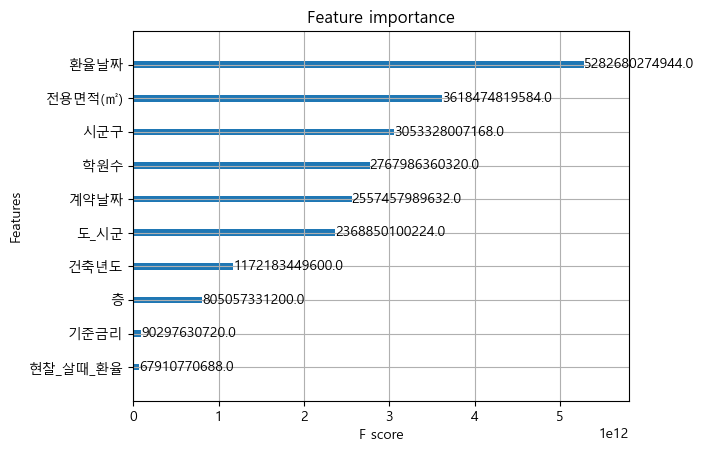

In [139]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows의 경우 'Malgun Gothic', Mac의 경우 'AppleGothic')
plt.rcParams['font.family'] = 'Malgun Gothic'  # 'Malgun Gothic' 대신 시스템에 있는 한글 폰트를 입력하세요.
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# Feature Importance 다시 그리기
from xgboost import plot_importance

plot_importance(xgb, importance_type='gain')
# plot_importance(xgb, importance_type='gain', max_num_features=10)  # 상위 10개만 표시
plt.rcParams["figure.figsize"] = (10, 8)  # 그래프 크기 조절
plt.show()

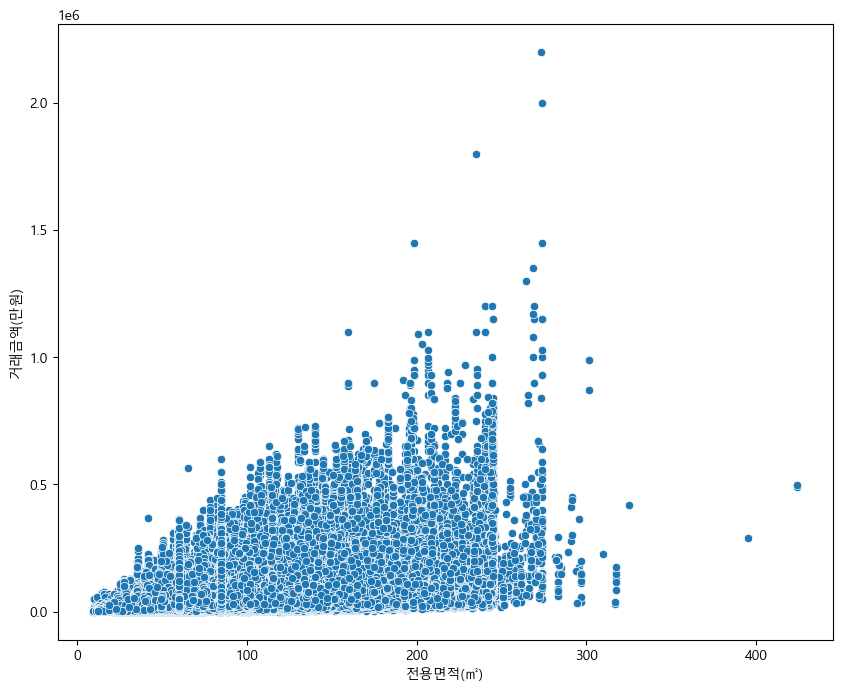

MemoryError: Unable to allocate 153. MiB for an array with shape (2, 10041336) and data type float64

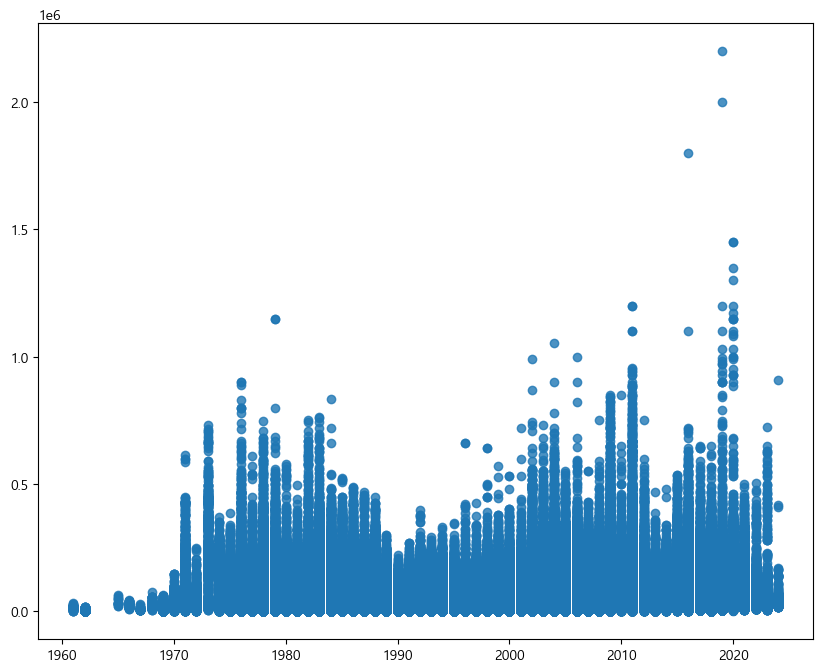

In [142]:
# 전용면적과 거래금액 간의 산점도 그리기
sns.scatterplot(data=data, x='전용면적(㎡)', y='거래금액(만원)')
plt.show()

# 건축년도와 거래금액 간의 관계
sns.regplot(data=data, x='건축년도', y='거래금액(만원)')
plt.show()


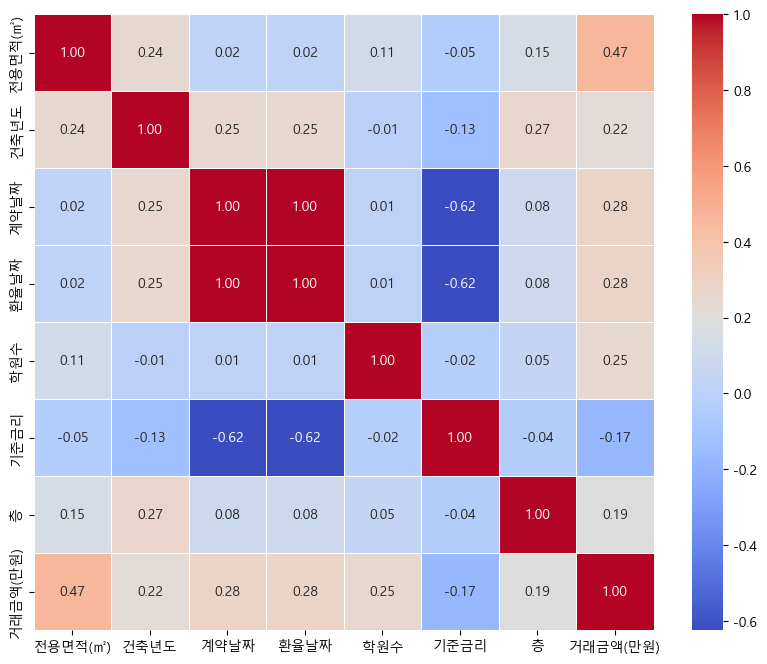

In [141]:
# 상관계수 계산
corr_matrix = data[selected_columns].corr()

# 상관행렬 heatmap 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# 그래프 보여주기
plt.show()

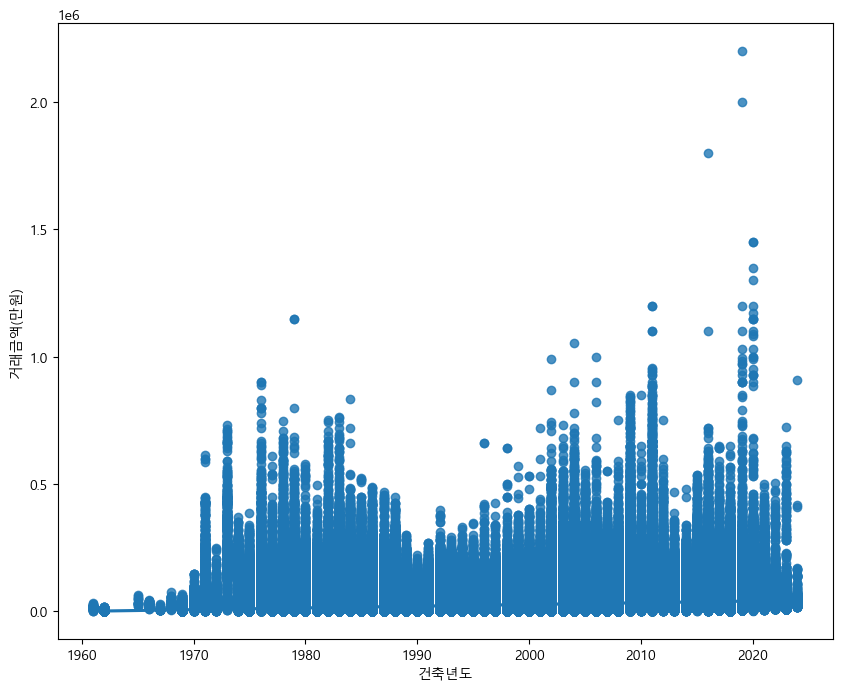

In [143]:
# 건축년도와 거래금액 간의 관계
sns.regplot(data=data, x='건축년도', y='거래금액(만원)')
plt.show()

In [ ]:
#########################data2#########################

In [132]:
data2['환율날짜'] = pd.to_datetime(data2['환율날짜'])

In [133]:
data2['환율날짜'] = data2['환율날짜'].dt.strftime('%Y%m%d')

In [134]:
data2['환율날짜'] = data2['환율날짜'].astype(int)

In [135]:
data2

,시군구,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,기준금리
0,강원특별자치도 양구군 양구읍 상리,기타,59.4000,"5,000",11,1998.0,2005-09-23,20050923,1061.83,강원특별자치도 양구군,24,3.25
1,경기도 의정부시 신곡동,기타,59.8780,"5,750",3,1997.0,2005-10-20,20051020,1077.02,경기도 의정부시,1151,3.50
2,경기도 의정부시 신곡동,기타,49.8300,"5,500",8,1998.0,2005-10-20,20051020,1077.02,경기도 의정부시,1151,3.50
3,경기도 의정부시 민락동,기타,84.9900,"12,750",19,2003.0,2005-10-30,20051028,1073.67,경기도 의정부시,1151,3.50
4,경기도 의정부시 용현동,기타,129.7300,"12,200",11,1992.0,2005-11-21,20051121,1060.19,경기도 의정부시,1151,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,대구광역시 달서구 진천동,기타,68.3360,"46,800",31,2022.0,2024-08-31,20240830,1362.43,대구광역시 달서구,1798,3.50
10041447,대구광역시 달서구 진천동,기타,68.3360,"46,800",31,2022.0,2024-08-31,20240830,1362.43,대구광역시 달서구,1798,3.50
10041448,대구광역시 달서구 진천동,기타,84.9080,"62,000",35,2022.0,2024-08-31,20240830,1362.43,대구광역시 달서구,1798,3.50
10041449,서울특별시 양천구 신정동,기타,54.9400,"139,000",12,1987.0,2024-08-31,20240830,1362.43,서울특별시 양천구,2126,3.50


In [153]:
data2['계약날짜'] = pd.to_datetime(data2['계약날짜'])

In [154]:
data2['계약날짜'] = data2['계약날짜'].dt.strftime('%Y%m%d')

In [155]:
data2['계약날짜'] = data2['계약날짜'].astype(int)

In [161]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data2['도_시군'] = label_encoder.fit_transform(data2['도_시군'])
data2['시군구'] = label_encoder.fit_transform(data2['시군구'])

In [162]:
data2

,시군구,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜,환율날짜,현찰_살때_환율,도_시군,학원수,...,단지명_삼성,단지명_삼익,단지명_성원,단지명_우성,단지명_주공,단지명_주공1,단지명_주공2,단지명_주공3,단지명_한신,단지명_현대
0,76,59.4000,"5,000",11,1998.0,20050923,20050923,1061.83,5,24,...,False,False,False,False,False,False,False,False,False,False
1,853,59.8780,"5,750",3,1997.0,20051020,20051020,1077.02,42,1151,...,False,False,False,False,False,False,False,False,False,False
2,853,49.8300,"5,500",8,1998.0,20051020,20051020,1077.02,42,1151,...,False,False,False,False,False,False,False,False,False,False
3,851,84.9900,"12,750",19,2003.0,20051030,20051028,1073.67,42,1151,...,False,False,False,False,False,False,False,False,False,False
4,854,129.7300,"12,200",11,1992.0,20051121,20051121,1060.19,42,1151,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10041446,2124,68.3360,"46,800",31,2022.0,20240831,20240830,1362.43,96,1798,...,False,False,False,False,False,False,False,False,False,False
10041447,2124,68.3360,"46,800",31,2022.0,20240831,20240830,1362.43,96,1798,...,False,False,False,False,False,False,False,False,False,False
10041448,2124,84.9080,"62,000",35,2022.0,20240831,20240830,1362.43,96,1798,...,False,False,False,False,False,False,False,False,False,False
10041449,2700,54.9400,"139,000",12,1987.0,20240831,20240830,1362.43,142,2126,...,False,False,False,False,False,False,False,False,False,False


In [167]:
data2['거래금액(만원)'] = data2['거래금액(만원)'].str.replace(",", "").astype(float)

In [168]:
X = data2.drop(['거래금액(만원)'], axis=1)
y = data2['거래금액(만원)']

In [169]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% valid, 15% test

In [172]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score  # 필요한 함수 불러오기

In [173]:
xgb = XGBRegressor(n_estimators=500, max_depth=3, n_jobs=-1, random_state=7)

# 모델 학습 (Train 데이터 사용)
xgb.fit(X_train, y_train)

# Validation 데이터로 예측 수행
valid_pred = xgb.predict(X_valid)

# 모델 평가 (Validation 데이터)
valid_mse = mean_squared_error(y_valid, valid_pred)
valid_rmse = np.sqrt(valid_mse)
valid_r2 = r2_score(y_valid, valid_pred)

print('Validation Set:')
print('Mean Squared Error (MSE):', valid_mse)
print('Root Mean Squared Error (RMSE):', valid_rmse)
print('R-squared:', valid_r2)

Validation Set:
Mean Squared Error (MSE): 79706910.07563369
Root Mean Squared Error (RMSE): 8927.87265117697
R-squared: 0.8911966522725524


In [174]:
# Test 데이터로 예측 수행
test_pred = xgb.predict(X_test)

# 모델 평가 (Test 데이터)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_pred)

print('\nTest Set:')
print('Mean Squared Error (MSE):', test_mse)
print('Root Mean Squared Error (RMSE):', test_rmse)
print('R-squared:', test_r2)


Test Set:
Mean Squared Error (MSE): 80720508.5215079
Root Mean Squared Error (RMSE): 8984.459278192979
R-squared: 0.8917702045362972


C:\Users\5-04\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\5-04\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\5-04\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\5-04\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\5-04\miniforge3\envs\fintech\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG

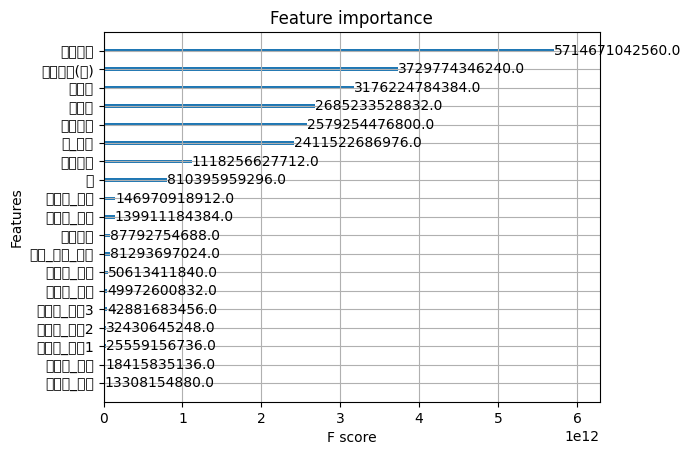

In [176]:
from xgboost import plot_importance

plot_importance(xgb, importance_type='gain')
plt.show()

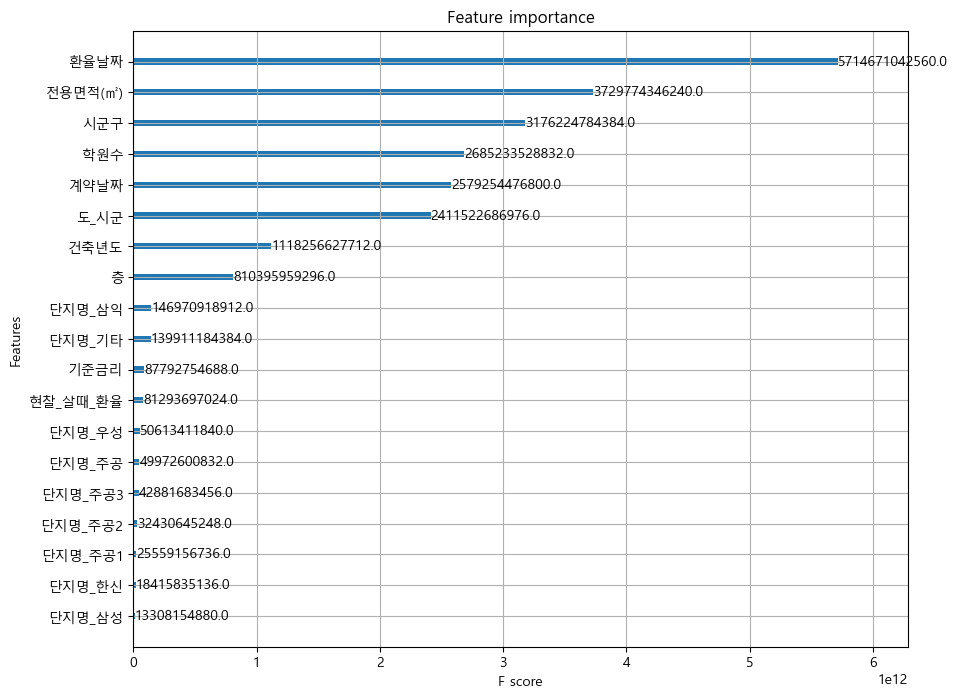

In [178]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows의 경우 'Malgun Gothic', Mac의 경우 'AppleGothic')
plt.rcParams['font.family'] = 'Malgun Gothic'  # 'Malgun Gothic' 대신 시스템에 있는 한글 폰트를 입력하세요.
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# Feature Importance 다시 그리기
from xgboost import plot_importance

plot_importance(xgb, importance_type='gain')
# plot_importance(xgb, importance_type='gain', max_num_features=10)  # 상위 10개만 표시
plt.rcParams["figure.figsize"] = (10, 8)  # 그래프 크기 조절
plt.show()

In [ ]:
# 모델의 예측에 얼마나 기여했는지를 보여

* Validation Set: train_test_split을 사용하여 전체 데이터를 훈련(train), 검증(validation), 테스트(test) 셋으로 분리했습니다. 훈련 70%, 검증 15%, 테스트 15%로 나눴습니다.
* early_stopping_rounds: 검증 데이터에서 10번 이상 성능이 향상되지 않으면 학습을 중단하여 최적의 모델을 찾을 수 있습니다.
* eval_set: 검증 세트를 지정하여 학습 도중 성능을 체크합니다